In [487]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import csv
import pickle

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

In [488]:
#generate hog features from image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    features = None
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features

In [489]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [490]:
#generate color features from image
def get_color_features(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    color_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return np.ravel(color_features)

In [491]:
#generate spatial features from image
def get_spatial_features(img, spatial_size=(32, 32)):
    spatial_feature = cv2.resize(img, spatial_size).ravel()
    return spatial_feature

In [492]:
#extract hog features from lots of image files
def extract_features(imgs, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size = (32, 32), use_spatial_feature=False, use_color_feature=False):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image) 
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #print('shape of hog features: ', hog_features.shape)
        combine_features = None
        if use_spatial_feature:
            spatial_features = get_spatial_features(feature_image, spatial_size)
            #print('shape of spatial features: ', spatial_features.shape)
            #print('shape of combine features: ', combine_features.shape)
            combine_features = spatial_features
        if use_color_feature:
            color_features = get_color_features(feature_image)  
            #print('shape of color features: ', color_features.shape)
            combine_features = np.concatenate((combine_features, color_features))
            #combine_features.append(color_features)
        if combine_features is not None:
            combine_features = np.concatenate((combine_features, hog_features))
        else:
            combine_features = hog_features
        features.append(combine_features)
    return features

In [493]:
#find car boxes
def find_car_boxes(img, ystart, ystop, scale, color_space, conv_color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv_color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #hog_feature1 = get_hog_features(subimg[:,:,0], orient, pix_per_cell, cell_per_block)
            #hog_feature2 = get_hog_features(subimg[:,:,1], orient, pix_per_cell, cell_per_block)
            #hog_feature3 = get_hog_features(subimg[:,:,2], orient, pix_per_cell, cell_per_block)
            
            #hog_features = np.hstack((hog_feature1, hog_feature2, hog_feature3))
            spatial_features = get_spatial_features(subimg, spatial_size=spatial_size)
            hist_features = get_color_features(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print('shape of hog features: ', hog_features.shape)
            #print('shape of spatial features: ', spatial_features.shape)
            #print('shape of hist features: ', hist_features.shape)
            #combine_features = np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1)
            #combine_features = hog_features
            #print('shape of combine features: ', combine_features.shape)
            #test_features = X_scaler.transform(combine_features)    
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print('shape of test features: ', test_features)
            #test_prediction = svc.predict(combine_features.reshape(-1, 1))
            test_prediction = svc.predict(test_features)
            #test_prediction = svc.decision_function(test_features)
            #print("test prediction: ", test_prediction)
            if test_prediction == 1:
                #print('car found')
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                p1 = (xbox_left, ytop_draw+ystart)
                p2 = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_img,p1,p2,(0,0,255),6) 
                car_boxes.append((p1, p2))
                
    return draw_img, car_boxes

In [494]:
#find training images from non-vehicles.zip, vehicles.zip
def get_images_from_path(file_path):
    non_cars_file_path = "%s/%s/*/*.png" % (file_path, "non-vehicles")
    cars_file_path = "%s/%s/*/*.png" % (file_path, "vehicles")
    non_cars = glob.glob(non_cars_file_path)
    cars = glob.glob(cars_file_path)
    return non_cars, cars
    
#find training images from labels_crowdai.csv 
def get_images_from_annotation(file_path):
    with open(file_path, 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            pass
    non_cars = []
    cars = []
    return non_cars, cars

In [495]:
#show hog features
def show_hog_features():
    non_cars, cars = get_images_from_path("train_data")
    non_car_index = np.random.randint(0, len(non_cars))
    car_index = np.random.randint(0, len(cars))
    non_car_image_source = mpimg.imread(non_cars[non_car_index])
    car_image_source = mpimg.imread(cars[car_index])
    non_car_image = convert_color(non_car_image_source, conv="RGB2YCrCb")
    car_image = convert_color(car_image_source, conv="RGB2YCrCb")
    _, non_car_hog_image = get_hog_features(non_car_image[:,:,0], 8, 8, 2, vis=True, feature_vec=False)
    _, car_hog_image = get_hog_features(car_image[:,:,0], 8, 8, 2, vis=True, feature_vec=False)
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(231)
    plt.imshow(non_car_image_source, cmap='gray')
    plt.title('example of non car image source (RGB)')
    plt.subplot(232)
    plt.imshow(non_car_image, cmap='gray')
    plt.title('example of non car image (YCrCb)')
    plt.subplot(233)
    plt.imshow(non_car_hog_image, cmap='gray')
    plt.title('hog example of non car image (HOG)')
    
    plt.subplot(234)
    plt.imshow(car_image_source, cmap='gray')
    plt.title('example of car image source (RGB)')
    plt.subplot(235)
    plt.imshow(car_image, cmap='gray')
    plt.title('example of car image (YcrCb)')
    plt.subplot(236)
    plt.imshow(car_hog_image, cmap='gray')
    plt.title('hog example of car image (HOG)')

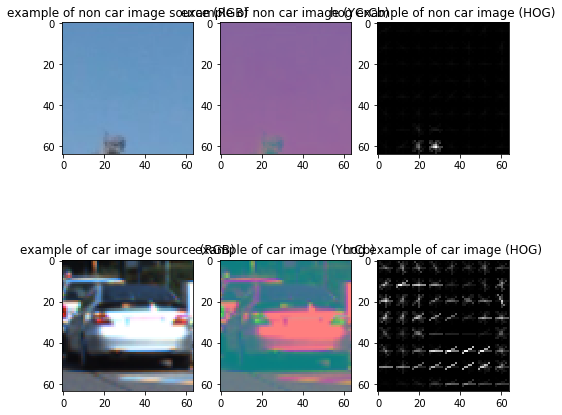

In [496]:
show_hog_features()

In [497]:
#generate train data
def generate_train_data(color_space, spatial_size):
    #parameters of hog feature
    #colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #colorspace = 'YUV'
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    #spatial_size = (32, 32)
    use_spatial_feature = True
    use_color_feature = True
    
    non_cars, cars = get_images_from_path("train_data")
    
    t1 = time.time()
    
    car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = spatial_size, use_spatial_feature=use_spatial_feature, use_color_feature=use_color_feature)
    non_car_features = extract_features(non_cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = spatial_size, use_spatial_feature=use_spatial_feature, use_color_feature=use_color_feature)
    
    t2 = time.time()
    
    print('extract features takes %d seconds' % round(t2 - t1, 2))
    
    X = np.vstack((car_features, non_car_features)).astype(np.float64)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    
    return X, y

In [498]:
#split data into training set and test test
def split_train_data(X, y):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, y_train, X_test, y_test, X_scaler

In [499]:
#find cars from image data
def find_cars(svc, X_scaler, y_start, y_stop, scale, color_space, conv_color_space, spatial_size, image_path, is_show = False):
    img = mpimg.imread(image_path)
    return find_cars_from_image_data(svc, X_scaler, y_start, y_stop, scale, color_space, conv_color_space, spatial_size, img, is_show)

In [516]:
#find cars
def find_cars_from_image_data(svc, X_scaler, y_start, y_stop, scale, color_space, conv_color_space, spatial_size, image, is_show):
    img = np.copy(image)
    
    #ystart = 300
    #ystop = 656
    #scale = 1.5
    #conv_color_space = 'RGB2YUV'
    
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    
    #spatial_size = (32, 32)
    hist_bins = 32
    
    t1 = time.time()
    out_img, out_boxes = find_car_boxes(img, y_start, y_stop, scale, color_space, conv_color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    t2 = time.time()
    print("find car boxes takes %d seconds" % round(t2 - t1, 2))
    
    if is_show:
        plt.figure()
        plt.imshow(out_img)
        
    return out_boxes

In [539]:
#find and draw
def find_cars_and_draw_outbox(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, image):
    out_boxes = find_cars_from_image_data(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, image)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = generate_heatmap(heatmap, out_boxes)
    heatmap = apply_heatmap_threshold(heatmap, 1)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [580]:
#find and draw
def find_cars_and_draw_outbox_for_multi_scales(svc, X_scaler, scales, color_space, conv_color_space, spatial_size, image):
    out_boxes = []
    for (scale, y_start, y_stop) in scales:
        out_box = find_cars_from_image_data(svc, X_scaler, y_start, y_stop, scale, color_space, conv_color_space, spatial_size, image, is_show=False)
        out_boxes.extend(out_box)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = generate_heatmap(heatmap, out_boxes)
    heatmap = apply_heatmap_threshold(heatmap, 4)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [572]:
#add heat
def generate_heatmap(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [573]:
#filter 
def apply_heatmap_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [574]:
#draw labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [575]:
#train with hyper parameters
def train_with_hyper_params():
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    scores = ['precision', 'recall']
    
    X, y = generate_train_data()
    
    X_train, y_train, X_test, y_test, X_scaler = split_train_data(X, y)
    #svc = LinearSVC()
    #svc.fit(X_train, y_train)
    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
        # 用训练集训练这个学习器 clf
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()

        # 再调用 clf.best_params_ 就能直接得到最好的参数搭配结果
        print(clf.best_params_)

        print()
        print("Grid scores on development set:")
        print()

        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']

        # 看一下具体的参数间不同数值的组合后得到的分数是多少
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))

        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
    
        #y_true, y_pred = y_test, clf.predict(X_test)

        # 打印在测试集上的预测结果与真实值的分数
        #print(classification_report(y_true, y_pred))

        #print()   

In [507]:
#train 
def train():
    
    color_space = 'YCrCb'
    conv_color_space = 'RGB2YCrCb'
    #color_space = 'YUV'
    #conv_color_space = 'RGB2YUV'
    
    spatial_size = (32, 32)
    
    X, y = generate_train_data(color_space, spatial_size)
    
    X_train, y_train, X_test, y_test, X_scaler = split_train_data(X, y)
    
    t1 = time.time()
    svc = LinearSVC()
    #svc = LinearSVC(C=10)
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    
    hist_bins = 32
    
    scale = 1.0
    
    print('shape of X_train: ', X_train.shape)
    
    svc_params = svc.get_params(True)
    
    print('svc params: ', svc_params)
    
    po = {"svc": svc, "svc_params": svc_params, "X_scaler": X_scaler, "color_space": color_space, 'conv_color_space': conv_color_space,  
          "orient": orient, "pix_per_cell": pix_per_cell, "cell_per_block": cell_per_block, 
         "spatial_size": spatial_size, "hist_bins": hist_bins}
    
    pickle.dump(po, open("svc_pickle.p", "wb"))

    print("time of SVC training: %d seconds" % round(t2 - t1, 2))
    print("accuracy of SVC classify: ", round(svc.score(X_test, y_test), 4))

    n_predict = 10

    print("labels of SVC predict: ", svc.predict(X_test[0:n_predict]))
    print("labels of actual data: ", y_test[0:n_predict])

    t3 = time.time()

    print("time of SVC predict: %d seconds" % round(t3-t2, 5))
    
    find_cars(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, "test_images/test1.jpg", is_show = True)
    find_cars(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, "test_images/test2.jpg", is_show = True)
    find_cars(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, "test_images/test3.jpg", is_show = True)
    find_cars(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, "test_images/test4.jpg", is_show = True)
    find_cars(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, "test_images/test5.jpg", is_show = True)

extract features takes 72 seconds
shape of X_train:  (14208, 9636)
svc params:  {'fit_intercept': True, 'intercept_scaling': 1, 'random_state': None, 'C': 1.0, 'class_weight': None, 'max_iter': 1000, 'tol': 0.0001, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2', 'verbose': 0, 'multi_class': 'ovr'}
time of SVC training: 19 seconds
accuracy of SVC classify:  0.9851
labels of SVC predict:  [ 1.  1.  0.  0.  1.  0.  1.  1.  0.  1.]
labels of actual data:  [ 1.  1.  0.  0.  1.  0.  1.  1.  1.  1.]
time of SVC predict: 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


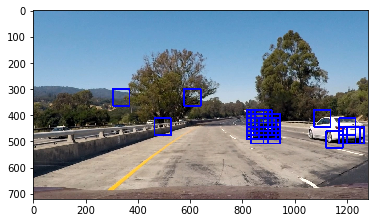

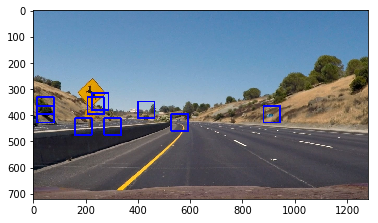

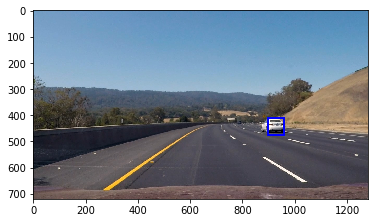

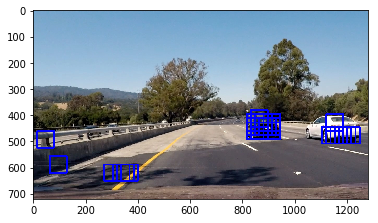

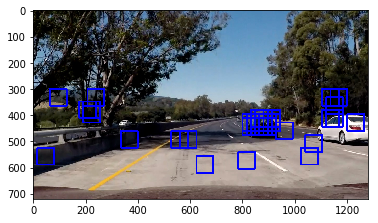

In [476]:
train()

In [576]:
#processing video image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

count = 0
po = pickle.load(open("svc_pickle.p", "rb"))
svc = po["svc"]
X_scaler = po['X_scaler']
#scales = [(1, 400, 464), (1.5, 400, 600), (2.0, 400, 656)]
scales = [(1, 400, 464),(1, 416, 480), (1.5, 400, 496), (1.5, 432, 528), (2.0, 400, 528), (2.0, 432, 560), (3.5, 400, 596), (3.5, 464, 660)]
color_space = po['color_space']
conv_color_space = po['conv_color_space']
spatial_size = po['spatial_size']

def video_image_process(image):
    global count
    global svc
    global X_scaler
    global scales
    global color_space
    global conv_color_space
    global spatial_size
    result = find_cars_and_draw_outbox_for_multi_scales(svc, X_scaler, scales, color_space, conv_color_space, spatial_size, image)
#     count = count + 1
#     if count % 50 == 0:
#         mpimg.imsave('test_video_images/%05d.jpg' % count, image)
    return result

In [577]:
#video detection
def video_detection(svc, X_scaler, color_space, conv_color_space, spatial_size):
    
    video_list = glob.glob("./*.mp4")
    print(video_list)
    for video_file in video_list:
        clip1 = VideoFileClip(video_file)
        print('do processing: ', video_file)
        white_clip = clip1.fl_image(video_image_process) #NOTE: this function expects color images!!
        white_output = 'output_videos/%s' % video_file
        %time white_clip.write_videofile(white_output, audio=False)

In [581]:
#main
def main():
    po = pickle.load(open("svc_pickle.p", "rb"))
    svc = po["svc"]
    svc_params = po["svc_params"]
    svc.set_params(**svc_params)
    X_scaler = po['X_scaler']
    color_space = po['color_space']
    conv_color_space = po['conv_color_space']
    spatial_size = po['spatial_size']
    video_detection(svc, X_scaler, color_space, conv_color_space, spatial_size)
    #test_example_images(svc, X_scaler)
    #test_video_images(svc, X_scaler)
    #test_video_images_for_multi_scales(svc, X_scaler, color_space, conv_color_space, spatial_size)
    #test_example_images_for_multi_scales(svc, X_scaler, color_space, conv_color_space, spatial_size)

In [582]:
main()

['./project_video.mp4', './test_video.mp4']
do processing:  ./project_video.mp4
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
[MoviePy] >>>> Building video output_videos/./project_video.mp4
[MoviePy] Writing video output_videos/./project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  0%|          | 1/1261 [00:00<10:13,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  0%|          | 2/1261 [00:00<10:19,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  0%|          | 3/1261 [00:01<10:20,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  0%|          | 4/1261 [00:01<10:25,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  0%|          | 5/1261 [00:02<10:27,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  0%|          | 6/1261 [00:02<10:26,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 7/1261 [00:03<10:25,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 8/1261 [00:03<10:23,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 9/1261 [00:04<10:27,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 10/1261 [00:04<10:23,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 11/1261 [00:05<10:23,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 12/1261 [00:05<10:22,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 13/1261 [00:06<10:19,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 14/1261 [00:06<10:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|          | 15/1261 [00:07<10:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|▏         | 16/1261 [00:07<10:15,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|▏         | 17/1261 [00:08<10:15,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  1%|▏         | 18/1261 [00:08<10:16,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 19/1261 [00:09<10:16,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 20/1261 [00:09<10:17,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 21/1261 [00:10<10:31,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 22/1261 [00:10<10:24,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 23/1261 [00:11<10:24,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 24/1261 [00:11<10:25,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 25/1261 [00:12<10:20,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 26/1261 [00:12<10:19,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 27/1261 [00:13<10:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 28/1261 [00:13<10:14,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 29/1261 [00:14<10:07,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 30/1261 [00:14<10:03,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  2%|▏         | 31/1261 [00:15<09:59,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 32/1261 [00:15<09:55,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 33/1261 [00:16<09:54,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 34/1261 [00:16<09:52,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 35/1261 [00:17<09:51,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 36/1261 [00:17<09:51,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 37/1261 [00:18<09:50,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 38/1261 [00:18<09:50,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 39/1261 [00:19<09:50,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 40/1261 [00:19<09:50,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 41/1261 [00:20<09:49,  2.07it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 42/1261 [00:20<09:50,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 43/1261 [00:21<09:55,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 44/1261 [00:21<09:52,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▎         | 45/1261 [00:22<09:52,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▎         | 46/1261 [00:22<09:49,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▎         | 47/1261 [00:23<09:53,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 48/1261 [00:23<10:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 49/1261 [00:24<09:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 50/1261 [00:24<09:59,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 51/1261 [00:25<09:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 52/1261 [00:25<09:59,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 53/1261 [00:26<09:55,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 54/1261 [00:26<09:52,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 55/1261 [00:27<09:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  4%|▍         | 56/1261 [00:27<09:49,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 57/1261 [00:28<09:50,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 58/1261 [00:28<09:47,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 59/1261 [00:29<09:46,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 60/1261 [00:29<09:50,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 61/1261 [00:30<10:05,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 62/1261 [00:30<10:00,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▍         | 63/1261 [00:31<09:57,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 64/1261 [00:31<09:53,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 65/1261 [00:32<09:53,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 66/1261 [00:32<09:52,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 67/1261 [00:33<09:50,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 68/1261 [00:33<09:56,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 69/1261 [00:34<09:54,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 70/1261 [00:34<09:51,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 71/1261 [00:35<09:47,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 72/1261 [00:35<09:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 73/1261 [00:36<09:43,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 74/1261 [00:36<09:39,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 75/1261 [00:37<09:41,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 76/1261 [00:37<09:38,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 77/1261 [00:37<09:38,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▌         | 78/1261 [00:38<09:37,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▋         | 79/1261 [00:38<09:36,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▋         | 80/1261 [00:39<09:39,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  6%|▋         | 81/1261 [00:39<09:38,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 82/1261 [00:40<09:38,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 83/1261 [00:40<09:45,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 84/1261 [00:41<09:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 85/1261 [00:41<09:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 86/1261 [00:42<09:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 87/1261 [00:42<09:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 88/1261 [00:43<09:36,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 89/1261 [00:43<09:33,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 90/1261 [00:44<09:34,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 91/1261 [00:44<09:31,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 92/1261 [00:45<09:31,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 93/1261 [00:45<09:30,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  7%|▋         | 94/1261 [00:46<09:38,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 95/1261 [00:46<09:36,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 96/1261 [00:47<09:31,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 97/1261 [00:47<09:29,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 98/1261 [00:48<09:27,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 99/1261 [00:48<09:25,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 100/1261 [00:49<09:27,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 101/1261 [00:49<09:25,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 102/1261 [00:50<09:25,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 103/1261 [00:50<09:26,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 104/1261 [00:51<09:24,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 105/1261 [00:51<09:36,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 106/1261 [00:52<09:31,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 107/1261 [00:52<09:28,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▊         | 108/1261 [00:53<09:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▊         | 109/1261 [00:53<09:27,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▊         | 110/1261 [00:54<09:27,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 111/1261 [00:54<09:24,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 112/1261 [00:55<09:23,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 113/1261 [00:55<09:22,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 114/1261 [00:56<09:20,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 115/1261 [00:56<09:22,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 116/1261 [00:57<09:19,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 117/1261 [00:57<09:19,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 118/1261 [00:58<09:22,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  9%|▉         | 119/1261 [00:58<09:20,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 120/1261 [00:59<09:23,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 121/1261 [00:59<09:19,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 122/1261 [01:00<09:17,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 123/1261 [01:00<09:18,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 124/1261 [01:01<09:16,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 125/1261 [01:01<09:17,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|▉         | 126/1261 [01:02<09:14,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 127/1261 [01:02<09:13,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 128/1261 [01:03<09:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 129/1261 [01:03<09:15,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 130/1261 [01:04<09:16,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 131/1261 [01:04<09:13,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 132/1261 [01:05<09:13,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 133/1261 [01:05<09:17,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 134/1261 [01:05<09:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 135/1261 [01:06<09:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 136/1261 [01:06<09:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 137/1261 [01:07<09:12,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 138/1261 [01:07<09:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 139/1261 [01:08<09:10,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 140/1261 [01:08<09:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█         | 141/1261 [01:09<09:11,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█▏        | 142/1261 [01:09<09:10,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█▏        | 143/1261 [01:10<09:12,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█▏        | 144/1261 [01:10<09:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 11%|█▏        | 145/1261 [01:11<09:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 146/1261 [01:11<09:07,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 147/1261 [01:12<09:15,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 148/1261 [01:12<09:11,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 149/1261 [01:13<09:11,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 150/1261 [01:13<09:09,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 151/1261 [01:14<09:05,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 152/1261 [01:14<09:05,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 153/1261 [01:15<09:03,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 154/1261 [01:15<09:01,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 155/1261 [01:16<09:06,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 156/1261 [01:16<09:10,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 12%|█▏        | 157/1261 [01:17<09:07,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 158/1261 [01:17<09:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 159/1261 [01:18<09:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 160/1261 [01:18<09:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 161/1261 [01:19<09:02,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 162/1261 [01:19<09:03,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 163/1261 [01:20<09:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 164/1261 [01:20<08:58,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 165/1261 [01:21<09:03,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 166/1261 [01:21<09:00,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 167/1261 [01:22<09:10,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 168/1261 [01:22<09:05,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 169/1261 [01:23<09:01,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 170/1261 [01:23<09:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▎        | 171/1261 [01:24<08:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▎        | 172/1261 [01:24<08:57,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▎        | 173/1261 [01:25<08:55,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 174/1261 [01:25<08:54,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 175/1261 [01:26<08:53,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 176/1261 [01:26<08:52,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 177/1261 [01:27<08:51,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 178/1261 [01:27<08:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 179/1261 [01:28<08:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 180/1261 [01:28<08:54,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 181/1261 [01:29<08:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 14%|█▍        | 182/1261 [01:29<08:49,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 183/1261 [01:30<08:49,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 184/1261 [01:30<08:47,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 185/1261 [01:31<08:46,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 186/1261 [01:31<08:46,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 187/1261 [01:32<08:47,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 188/1261 [01:32<08:51,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▍        | 189/1261 [01:33<08:49,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 190/1261 [01:33<08:52,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 191/1261 [01:34<08:49,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 192/1261 [01:34<08:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 193/1261 [01:35<08:49,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 194/1261 [01:35<08:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 195/1261 [01:36<08:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 196/1261 [01:36<08:46,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 197/1261 [01:37<08:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 198/1261 [01:37<08:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 199/1261 [01:38<08:42,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 200/1261 [01:38<08:43,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 201/1261 [01:39<08:42,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 202/1261 [01:39<08:41,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 203/1261 [01:40<08:41,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▌        | 204/1261 [01:40<08:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▋        | 205/1261 [01:41<08:41,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▋        | 206/1261 [01:41<08:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▋        | 207/1261 [01:42<08:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 16%|█▋        | 208/1261 [01:42<08:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 209/1261 [01:43<08:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 210/1261 [01:43<08:38,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 211/1261 [01:43<08:36,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 212/1261 [01:44<08:35,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 213/1261 [01:44<08:34,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 214/1261 [01:45<08:32,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 215/1261 [01:45<08:33,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 216/1261 [01:46<08:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 217/1261 [01:46<08:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 218/1261 [01:47<08:34,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 219/1261 [01:47<08:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 17%|█▋        | 220/1261 [01:48<08:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 221/1261 [01:48<08:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 222/1261 [01:49<08:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 223/1261 [01:49<08:33,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 224/1261 [01:50<08:34,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 225/1261 [01:50<08:37,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 226/1261 [01:51<08:46,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 227/1261 [01:51<08:40,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 228/1261 [01:52<08:38,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 229/1261 [01:52<08:36,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 230/1261 [01:53<08:34,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 231/1261 [01:53<08:32,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 232/1261 [01:54<08:34,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 233/1261 [01:54<08:35,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▊        | 234/1261 [01:55<08:33,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▊        | 235/1261 [01:55<08:33,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▊        | 236/1261 [01:56<08:32,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 237/1261 [01:56<08:33,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 238/1261 [01:57<08:29,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 239/1261 [01:57<08:42,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 240/1261 [01:58<08:39,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 241/1261 [01:58<08:35,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 242/1261 [01:59<08:34,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 243/1261 [01:59<08:31,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 244/1261 [02:00<08:31,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 19%|█▉        | 245/1261 [02:00<08:29,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 246/1261 [02:01<08:28,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 247/1261 [02:01<08:27,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 248/1261 [02:02<08:24,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 249/1261 [02:02<08:24,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 250/1261 [02:03<08:23,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 251/1261 [02:03<08:36,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|█▉        | 252/1261 [02:04<08:34,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|██        | 253/1261 [02:05<08:32,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|██        | 254/1261 [02:05<08:30,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|██        | 255/1261 [02:06<08:29,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|██        | 256/1261 [02:06<08:26,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|██        | 257/1261 [02:07<08:26,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 20%|██        | 258/1261 [02:07<08:25,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 259/1261 [02:08<08:24,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 260/1261 [02:08<08:25,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 261/1261 [02:09<08:22,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 262/1261 [02:09<08:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 263/1261 [02:10<08:17,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 264/1261 [02:10<08:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 265/1261 [02:11<08:16,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 266/1261 [02:11<08:15,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 267/1261 [02:12<08:18,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██▏       | 268/1261 [02:12<08:19,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██▏       | 269/1261 [02:13<08:19,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██▏       | 270/1261 [02:13<08:18,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██▏       | 271/1261 [02:14<08:15,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 272/1261 [02:14<08:14,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 273/1261 [02:15<08:23,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 274/1261 [02:15<08:19,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 275/1261 [02:16<08:14,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 276/1261 [02:16<08:19,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 277/1261 [02:17<08:15,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 278/1261 [02:17<08:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 279/1261 [02:18<08:07,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 280/1261 [02:18<08:05,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 281/1261 [02:19<08:04,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 282/1261 [02:19<08:03,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 22%|██▏       | 283/1261 [02:20<08:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 284/1261 [02:20<08:00,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 285/1261 [02:20<07:59,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 286/1261 [02:21<07:59,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 287/1261 [02:21<07:58,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 288/1261 [02:22<07:58,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 289/1261 [02:22<08:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 290/1261 [02:23<08:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 291/1261 [02:23<08:01,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 292/1261 [02:24<08:07,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 293/1261 [02:24<08:06,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 294/1261 [02:25<08:04,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 295/1261 [02:25<08:02,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 296/1261 [02:26<08:05,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▎       | 297/1261 [02:26<08:05,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▎       | 298/1261 [02:27<08:06,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▎       | 299/1261 [02:28<08:06,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 300/1261 [02:28<08:20,  1.92it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 301/1261 [02:29<08:12,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 302/1261 [02:29<08:08,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 303/1261 [02:30<08:22,  1.91it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 304/1261 [02:30<08:12,  1.94it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 305/1261 [02:31<08:04,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 306/1261 [02:31<08:01,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 307/1261 [02:32<07:57,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 24%|██▍       | 308/1261 [02:32<07:55,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 309/1261 [02:33<07:53,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 310/1261 [02:33<07:51,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 311/1261 [02:34<07:50,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 312/1261 [02:34<07:49,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 313/1261 [02:35<07:49,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 314/1261 [02:35<07:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▍       | 315/1261 [02:36<07:47,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▌       | 316/1261 [02:36<07:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▌       | 317/1261 [02:37<07:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▌       | 318/1261 [02:37<07:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▌       | 319/1261 [02:38<07:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▌       | 320/1261 [02:38<07:45,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 25%|██▌       | 321/1261 [02:39<07:45,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 322/1261 [02:39<07:45,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 323/1261 [02:40<07:45,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 324/1261 [02:40<07:43,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 325/1261 [02:40<07:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 326/1261 [02:41<07:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 327/1261 [02:41<07:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 328/1261 [02:42<07:43,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 329/1261 [02:42<07:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 330/1261 [02:43<07:42,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 331/1261 [02:43<07:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▋       | 332/1261 [02:44<07:47,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▋       | 333/1261 [02:44<07:45,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▋       | 334/1261 [02:45<07:42,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 335/1261 [02:45<07:41,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 336/1261 [02:46<07:40,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 337/1261 [02:46<07:41,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 338/1261 [02:47<07:37,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 339/1261 [02:47<07:42,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 340/1261 [02:48<07:41,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 341/1261 [02:48<07:40,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 342/1261 [02:49<07:44,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 343/1261 [02:49<07:41,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 344/1261 [02:50<07:38,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 345/1261 [02:50<07:36,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 27%|██▋       | 346/1261 [02:51<07:36,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 347/1261 [02:51<07:37,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 348/1261 [02:52<07:38,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 349/1261 [02:53<07:40,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 350/1261 [02:53<07:36,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 351/1261 [02:53<07:33,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 352/1261 [02:54<07:31,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 353/1261 [02:54<07:28,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 354/1261 [02:55<07:27,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 355/1261 [02:55<07:31,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 356/1261 [02:56<07:29,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 357/1261 [02:56<07:27,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 358/1261 [02:57<07:26,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 359/1261 [02:57<07:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▊       | 360/1261 [02:58<07:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▊       | 361/1261 [02:58<07:22,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▊       | 362/1261 [02:59<07:21,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 363/1261 [02:59<07:19,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 364/1261 [03:00<07:19,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 365/1261 [03:00<07:19,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 366/1261 [03:01<07:18,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 367/1261 [03:01<07:18,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 368/1261 [03:02<07:20,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 369/1261 [03:02<07:19,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 370/1261 [03:03<07:18,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 29%|██▉       | 371/1261 [03:03<07:18,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 372/1261 [03:04<07:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 373/1261 [03:04<07:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 374/1261 [03:05<07:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 375/1261 [03:05<07:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 376/1261 [03:06<07:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 377/1261 [03:06<07:16,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|██▉       | 378/1261 [03:07<07:15,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|███       | 379/1261 [03:07<07:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|███       | 380/1261 [03:08<07:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|███       | 381/1261 [03:08<07:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|███       | 382/1261 [03:09<07:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|███       | 383/1261 [03:09<07:12,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 30%|███       | 384/1261 [03:10<07:12,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 385/1261 [03:10<07:12,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 386/1261 [03:11<07:10,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 387/1261 [03:11<07:10,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 388/1261 [03:12<07:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 389/1261 [03:12<07:08,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 390/1261 [03:13<07:07,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 391/1261 [03:13<07:08,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 392/1261 [03:14<07:06,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 393/1261 [03:14<07:05,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 394/1261 [03:15<07:04,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███▏      | 395/1261 [03:15<07:05,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███▏      | 396/1261 [03:16<07:05,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███▏      | 397/1261 [03:16<07:04,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 398/1261 [03:17<07:09,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 399/1261 [03:17<07:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 400/1261 [03:18<07:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 401/1261 [03:18<07:04,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 402/1261 [03:19<07:03,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 403/1261 [03:19<07:02,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 404/1261 [03:20<07:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 405/1261 [03:20<07:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 406/1261 [03:21<07:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 407/1261 [03:21<07:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 408/1261 [03:22<07:00,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 32%|███▏      | 409/1261 [03:22<06:59,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 410/1261 [03:23<06:59,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 411/1261 [03:23<06:57,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 412/1261 [03:24<07:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 413/1261 [03:24<06:58,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 414/1261 [03:25<06:58,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 415/1261 [03:25<06:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 416/1261 [03:26<06:57,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 417/1261 [03:26<06:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 418/1261 [03:27<06:56,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 419/1261 [03:27<06:55,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 420/1261 [03:27<06:57,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 421/1261 [03:28<06:54,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 422/1261 [03:28<06:54,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▎      | 423/1261 [03:29<06:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▎      | 424/1261 [03:29<06:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▎      | 425/1261 [03:30<06:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 426/1261 [03:30<06:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 427/1261 [03:31<06:52,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 428/1261 [03:31<06:52,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 429/1261 [03:32<06:50,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 430/1261 [03:32<06:51,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 431/1261 [03:33<06:50,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 432/1261 [03:33<06:50,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 433/1261 [03:34<06:48,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 434/1261 [03:34<06:47,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 34%|███▍      | 435/1261 [03:35<06:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▍      | 436/1261 [03:35<06:47,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▍      | 437/1261 [03:36<06:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▍      | 438/1261 [03:36<06:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▍      | 439/1261 [03:37<06:46,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▍      | 440/1261 [03:37<06:47,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▍      | 441/1261 [03:38<06:51,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▌      | 442/1261 [03:38<06:50,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▌      | 443/1261 [03:39<06:48,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▌      | 444/1261 [03:39<06:45,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▌      | 445/1261 [03:40<06:44,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▌      | 446/1261 [03:40<06:42,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 35%|███▌      | 447/1261 [03:41<06:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 448/1261 [03:41<06:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 449/1261 [03:42<06:39,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 450/1261 [03:42<06:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 451/1261 [03:43<06:38,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 452/1261 [03:43<06:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 453/1261 [03:44<06:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 454/1261 [03:44<06:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 455/1261 [03:45<06:39,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 456/1261 [03:45<06:42,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 457/1261 [03:46<06:48,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▋      | 458/1261 [03:46<06:43,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▋      | 459/1261 [03:47<06:42,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▋      | 460/1261 [03:47<06:41,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 461/1261 [03:48<06:37,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 462/1261 [03:48<06:37,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 463/1261 [03:49<06:34,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 464/1261 [03:49<06:34,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 465/1261 [03:50<06:43,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 466/1261 [03:50<06:39,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 467/1261 [03:51<06:38,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 468/1261 [03:51<06:34,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 469/1261 [03:52<06:34,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 470/1261 [03:52<06:33,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 471/1261 [03:53<06:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 37%|███▋      | 472/1261 [03:53<06:31,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 473/1261 [03:54<06:29,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 474/1261 [03:54<06:29,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 475/1261 [03:55<06:28,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 476/1261 [03:55<06:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 477/1261 [03:56<06:28,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 478/1261 [03:56<06:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 479/1261 [03:57<06:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 480/1261 [03:57<06:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 481/1261 [03:58<06:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 482/1261 [03:58<06:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 483/1261 [03:59<06:25,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 484/1261 [03:59<06:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 485/1261 [04:00<06:22,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▊      | 486/1261 [04:00<06:22,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▊      | 487/1261 [04:01<06:24,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▊      | 488/1261 [04:01<06:21,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 489/1261 [04:02<06:22,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 490/1261 [04:02<06:20,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 491/1261 [04:03<06:18,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 492/1261 [04:03<06:19,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 493/1261 [04:04<06:18,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 494/1261 [04:04<06:19,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 495/1261 [04:05<06:19,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 496/1261 [04:05<06:16,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 497/1261 [04:06<06:17,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 39%|███▉      | 498/1261 [04:06<06:15,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|███▉      | 499/1261 [04:07<06:16,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|███▉      | 500/1261 [04:07<06:15,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|███▉      | 501/1261 [04:08<06:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|███▉      | 502/1261 [04:08<06:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|███▉      | 503/1261 [04:09<06:12,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|███▉      | 504/1261 [04:09<06:12,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|████      | 505/1261 [04:10<06:11,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|████      | 506/1261 [04:10<06:10,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|████      | 507/1261 [04:11<06:11,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|████      | 508/1261 [04:11<06:10,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|████      | 509/1261 [04:12<06:10,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 40%|████      | 510/1261 [04:12<06:08,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 511/1261 [04:13<06:07,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 512/1261 [04:13<06:07,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 513/1261 [04:14<06:06,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 514/1261 [04:14<06:06,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 515/1261 [04:14<06:06,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 516/1261 [04:15<06:04,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 517/1261 [04:15<06:05,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 518/1261 [04:16<06:06,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 519/1261 [04:16<06:09,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 520/1261 [04:17<06:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████▏     | 521/1261 [04:17<06:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████▏     | 522/1261 [04:18<06:11,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████▏     | 523/1261 [04:19<06:10,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 524/1261 [04:19<06:11,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 525/1261 [04:20<06:22,  1.92it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 526/1261 [04:20<06:55,  1.77it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 527/1261 [04:21<06:40,  1.83it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 528/1261 [04:21<06:32,  1.87it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 529/1261 [04:22<06:37,  1.84it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 530/1261 [04:22<06:52,  1.77it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 531/1261 [04:23<06:51,  1.78it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 532/1261 [04:24<06:48,  1.79it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 533/1261 [04:24<06:45,  1.80it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 534/1261 [04:25<06:43,  1.80it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 42%|████▏     | 535/1261 [04:25<06:39,  1.82it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 536/1261 [04:26<06:25,  1.88it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 537/1261 [04:26<06:20,  1.90it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 538/1261 [04:27<06:15,  1.93it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 539/1261 [04:27<06:09,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 540/1261 [04:28<06:07,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 541/1261 [04:28<06:11,  1.94it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 542/1261 [04:29<06:07,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 543/1261 [04:29<06:04,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 544/1261 [04:30<06:02,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 545/1261 [04:30<06:00,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 546/1261 [04:31<05:58,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 547/1261 [04:31<05:58,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 43%|████▎     | 548/1261 [04:32<05:56,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▎     | 549/1261 [04:32<05:54,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▎     | 550/1261 [04:33<05:53,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▎     | 551/1261 [04:33<05:52,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 552/1261 [04:34<05:51,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 553/1261 [04:34<05:50,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 554/1261 [04:35<05:50,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 555/1261 [04:35<05:50,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 556/1261 [04:36<05:49,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 557/1261 [04:36<05:49,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 558/1261 [04:37<05:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 559/1261 [04:37<05:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 560/1261 [04:38<05:46,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▍     | 561/1261 [04:38<05:46,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▍     | 562/1261 [04:39<05:45,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▍     | 563/1261 [04:39<05:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▍     | 564/1261 [04:40<05:43,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▍     | 565/1261 [04:40<05:43,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▍     | 566/1261 [04:41<05:44,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▍     | 567/1261 [04:41<05:44,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▌     | 568/1261 [04:42<05:44,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▌     | 569/1261 [04:42<05:43,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▌     | 570/1261 [04:43<05:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▌     | 571/1261 [04:43<05:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▌     | 572/1261 [04:44<05:37,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 45%|████▌     | 573/1261 [04:44<05:36,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 574/1261 [04:45<05:35,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 575/1261 [04:45<05:34,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 576/1261 [04:46<05:34,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 577/1261 [04:46<05:34,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 578/1261 [04:47<05:35,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 579/1261 [04:47<05:34,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 580/1261 [04:47<05:34,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 581/1261 [04:48<05:33,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 582/1261 [04:48<05:32,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 583/1261 [04:49<05:32,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▋     | 584/1261 [04:49<05:32,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▋     | 585/1261 [04:50<05:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▋     | 586/1261 [04:50<05:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 587/1261 [04:51<05:31,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 588/1261 [04:51<05:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 589/1261 [04:52<05:31,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 590/1261 [04:52<05:30,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 591/1261 [04:53<05:29,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 592/1261 [04:53<05:29,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 593/1261 [04:54<05:28,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 594/1261 [04:54<05:28,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 595/1261 [04:55<05:27,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 596/1261 [04:55<05:27,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 597/1261 [04:56<05:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 47%|████▋     | 598/1261 [04:56<05:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 599/1261 [04:57<05:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 600/1261 [04:57<05:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 601/1261 [04:58<05:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 602/1261 [04:58<05:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 603/1261 [04:59<05:29,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 604/1261 [04:59<05:27,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 605/1261 [05:00<05:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 606/1261 [05:00<05:22,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 607/1261 [05:01<05:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 608/1261 [05:01<05:26,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 609/1261 [05:02<05:30,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 610/1261 [05:02<05:29,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 48%|████▊     | 611/1261 [05:03<05:25,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▊     | 612/1261 [05:03<05:23,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▊     | 613/1261 [05:04<05:21,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▊     | 614/1261 [05:04<05:21,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 615/1261 [05:05<05:20,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 616/1261 [05:05<05:18,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 617/1261 [05:06<05:17,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 618/1261 [05:06<05:15,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 619/1261 [05:07<05:15,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 620/1261 [05:07<05:14,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 621/1261 [05:08<05:14,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 622/1261 [05:08<05:13,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 623/1261 [05:09<05:13,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▉     | 624/1261 [05:09<05:12,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|████▉     | 625/1261 [05:10<05:13,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|████▉     | 626/1261 [05:10<05:14,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|████▉     | 627/1261 [05:11<05:13,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|████▉     | 628/1261 [05:11<05:14,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|████▉     | 629/1261 [05:12<05:15,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|████▉     | 630/1261 [05:12<05:13,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|█████     | 631/1261 [05:13<05:14,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|█████     | 632/1261 [05:13<05:11,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|█████     | 633/1261 [05:14<05:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|█████     | 634/1261 [05:14<05:08,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|█████     | 635/1261 [05:15<05:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 50%|█████     | 636/1261 [05:15<05:11,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 637/1261 [05:16<05:09,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 638/1261 [05:16<05:06,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 639/1261 [05:17<05:07,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 640/1261 [05:17<05:05,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 641/1261 [05:18<05:04,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 642/1261 [05:18<05:03,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 643/1261 [05:19<05:01,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 644/1261 [05:19<05:00,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 645/1261 [05:20<04:59,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 646/1261 [05:20<04:58,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████▏    | 647/1261 [05:21<04:58,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████▏    | 648/1261 [05:21<04:57,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████▏    | 649/1261 [05:22<04:56,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 650/1261 [05:22<04:56,  2.06it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 651/1261 [05:23<05:00,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 652/1261 [05:23<04:59,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 653/1261 [05:23<04:57,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 654/1261 [05:24<04:57,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 655/1261 [05:24<04:56,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 656/1261 [05:25<04:56,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 657/1261 [05:25<04:55,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 658/1261 [05:26<04:56,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 659/1261 [05:26<04:59,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 660/1261 [05:27<04:59,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 661/1261 [05:27<05:01,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 52%|█████▏    | 662/1261 [05:28<04:58,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 663/1261 [05:28<04:56,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 664/1261 [05:29<04:55,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 665/1261 [05:29<04:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 666/1261 [05:30<04:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 667/1261 [05:30<04:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 668/1261 [05:31<04:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 669/1261 [05:31<04:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 670/1261 [05:32<04:50,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 671/1261 [05:32<04:49,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 672/1261 [05:33<04:49,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 673/1261 [05:33<04:49,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 53%|█████▎    | 674/1261 [05:34<04:51,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▎    | 675/1261 [05:34<04:50,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▎    | 676/1261 [05:35<04:48,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▎    | 677/1261 [05:35<04:46,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 678/1261 [05:36<04:45,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 679/1261 [05:36<04:44,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 680/1261 [05:37<04:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 681/1261 [05:37<04:44,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 682/1261 [05:38<04:46,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 683/1261 [05:38<04:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 684/1261 [05:39<04:43,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 685/1261 [05:39<04:43,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 686/1261 [05:40<04:42,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 687/1261 [05:40<04:41,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▍    | 688/1261 [05:41<04:46,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▍    | 689/1261 [05:41<04:44,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▍    | 690/1261 [05:42<04:42,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▍    | 691/1261 [05:42<04:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▍    | 692/1261 [05:43<04:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▍    | 693/1261 [05:43<04:39,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▌    | 694/1261 [05:44<04:42,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▌    | 695/1261 [05:44<04:41,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▌    | 696/1261 [05:45<04:39,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▌    | 697/1261 [05:45<04:38,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▌    | 698/1261 [05:46<04:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 55%|█████▌    | 699/1261 [05:46<04:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 700/1261 [05:47<04:36,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 701/1261 [05:47<04:35,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 702/1261 [05:48<04:35,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 703/1261 [05:48<04:34,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 704/1261 [05:49<04:34,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 705/1261 [05:49<04:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 706/1261 [05:50<04:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 707/1261 [05:50<04:34,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 708/1261 [05:51<04:33,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▌    | 709/1261 [05:51<04:33,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▋    | 710/1261 [05:52<04:32,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▋    | 711/1261 [05:52<04:32,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▋    | 712/1261 [05:53<04:31,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 713/1261 [05:53<04:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 714/1261 [05:54<04:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 715/1261 [05:54<04:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 716/1261 [05:55<04:29,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 717/1261 [05:55<04:30,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 718/1261 [05:56<04:28,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 719/1261 [05:56<04:28,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 720/1261 [05:57<04:27,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 721/1261 [05:57<04:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 722/1261 [05:58<04:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 723/1261 [05:58<04:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 724/1261 [05:59<04:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 57%|█████▋    | 725/1261 [05:59<04:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 726/1261 [06:00<04:23,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 727/1261 [06:00<04:23,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 728/1261 [06:01<04:22,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 729/1261 [06:01<04:23,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 730/1261 [06:01<04:22,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 731/1261 [06:02<04:22,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 732/1261 [06:02<04:22,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 733/1261 [06:03<04:23,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 734/1261 [06:03<04:23,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 735/1261 [06:04<04:22,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 736/1261 [06:04<04:21,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 58%|█████▊    | 737/1261 [06:05<04:21,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▊    | 738/1261 [06:05<04:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▊    | 739/1261 [06:06<04:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▊    | 740/1261 [06:06<04:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 741/1261 [06:07<04:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 742/1261 [06:07<04:18,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 743/1261 [06:08<04:18,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 744/1261 [06:08<04:18,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 745/1261 [06:09<04:18,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 746/1261 [06:09<04:16,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 747/1261 [06:10<04:16,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 748/1261 [06:10<04:15,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 749/1261 [06:11<04:14,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 750/1261 [06:11<04:13,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|█████▉    | 751/1261 [06:12<04:13,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|█████▉    | 752/1261 [06:12<04:12,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|█████▉    | 753/1261 [06:13<04:12,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|█████▉    | 754/1261 [06:13<04:12,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|█████▉    | 755/1261 [06:14<04:11,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|█████▉    | 756/1261 [06:14<04:10,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|██████    | 757/1261 [06:15<04:09,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|██████    | 758/1261 [06:15<04:08,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|██████    | 759/1261 [06:16<04:07,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|██████    | 760/1261 [06:16<04:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|██████    | 761/1261 [06:17<04:08,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 60%|██████    | 762/1261 [06:17<04:09,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 763/1261 [06:18<04:07,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 764/1261 [06:18<04:05,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 765/1261 [06:19<04:07,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 766/1261 [06:19<04:06,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 767/1261 [06:20<04:05,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 768/1261 [06:20<04:04,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 769/1261 [06:21<04:04,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 770/1261 [06:21<04:03,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 771/1261 [06:22<04:02,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████    | 772/1261 [06:22<04:02,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████▏   | 773/1261 [06:23<04:01,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████▏   | 774/1261 [06:23<04:01,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 61%|██████▏   | 775/1261 [06:24<04:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 776/1261 [06:24<03:59,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 777/1261 [06:25<04:02,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 778/1261 [06:25<04:03,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 779/1261 [06:26<04:02,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 780/1261 [06:26<04:00,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 781/1261 [06:27<03:58,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 782/1261 [06:27<03:57,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 783/1261 [06:28<03:59,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 784/1261 [06:28<03:59,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 785/1261 [06:29<03:57,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 786/1261 [06:29<03:57,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 787/1261 [06:30<03:55,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 788/1261 [06:30<03:54,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 789/1261 [06:31<03:53,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 790/1261 [06:31<03:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 791/1261 [06:32<03:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 792/1261 [06:32<03:50,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 793/1261 [06:33<03:50,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 794/1261 [06:33<03:49,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 795/1261 [06:34<03:49,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 796/1261 [06:34<03:49,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 797/1261 [06:35<03:48,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 798/1261 [06:35<03:48,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 799/1261 [06:36<03:47,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 63%|██████▎   | 800/1261 [06:36<03:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▎   | 801/1261 [06:37<03:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▎   | 802/1261 [06:37<03:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▎   | 803/1261 [06:38<03:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 804/1261 [06:38<03:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 805/1261 [06:39<03:49,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 806/1261 [06:39<03:48,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 807/1261 [06:40<03:46,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 808/1261 [06:40<03:48,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 809/1261 [06:41<03:46,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 810/1261 [06:41<03:44,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 811/1261 [06:42<03:43,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 812/1261 [06:42<03:41,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 813/1261 [06:43<03:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▍   | 814/1261 [06:43<03:43,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▍   | 815/1261 [06:44<03:42,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▍   | 816/1261 [06:44<03:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▍   | 817/1261 [06:45<03:39,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▍   | 818/1261 [06:45<03:41,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▍   | 819/1261 [06:46<03:40,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▌   | 820/1261 [06:46<03:38,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▌   | 821/1261 [06:47<03:37,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▌   | 822/1261 [06:47<03:36,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▌   | 823/1261 [06:48<03:36,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▌   | 824/1261 [06:48<03:35,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 65%|██████▌   | 825/1261 [06:49<03:35,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 826/1261 [06:49<03:34,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 827/1261 [06:50<03:34,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 828/1261 [06:50<03:33,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 829/1261 [06:51<03:33,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 830/1261 [06:51<03:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 831/1261 [06:52<03:32,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 832/1261 [06:52<03:34,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 833/1261 [06:53<03:32,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 834/1261 [06:53<03:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▌   | 835/1261 [06:54<03:29,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▋   | 836/1261 [06:54<03:29,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▋   | 837/1261 [06:55<03:28,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 66%|██████▋   | 838/1261 [06:55<03:27,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 839/1261 [06:56<03:27,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 840/1261 [06:56<03:26,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 841/1261 [06:57<03:25,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 842/1261 [06:57<03:24,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 843/1261 [06:58<03:24,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 844/1261 [06:58<03:24,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 845/1261 [06:59<03:24,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 846/1261 [06:59<03:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 847/1261 [07:00<03:25,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 848/1261 [07:00<03:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 849/1261 [07:01<03:24,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 850/1261 [07:01<03:26,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 851/1261 [07:02<03:27,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 852/1261 [07:02<03:26,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 853/1261 [07:03<03:24,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 854/1261 [07:03<03:23,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 855/1261 [07:04<03:23,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 856/1261 [07:04<03:22,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 857/1261 [07:05<03:22,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 858/1261 [07:05<03:21,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 859/1261 [07:06<03:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 860/1261 [07:06<03:20,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 861/1261 [07:07<03:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 862/1261 [07:07<03:17,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 68%|██████▊   | 863/1261 [07:08<03:16,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▊   | 864/1261 [07:08<03:18,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▊   | 865/1261 [07:09<03:19,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▊   | 866/1261 [07:09<03:18,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 867/1261 [07:10<03:16,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 868/1261 [07:10<03:16,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 869/1261 [07:11<03:15,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 870/1261 [07:11<03:14,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 871/1261 [07:12<03:13,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 872/1261 [07:12<03:12,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 873/1261 [07:13<03:11,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 874/1261 [07:13<03:10,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 875/1261 [07:13<03:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 876/1261 [07:14<03:10,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|██████▉   | 877/1261 [07:14<03:09,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|██████▉   | 878/1261 [07:15<03:08,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|██████▉   | 879/1261 [07:15<03:07,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|██████▉   | 880/1261 [07:16<03:07,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|██████▉   | 881/1261 [07:16<03:06,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|██████▉   | 882/1261 [07:17<03:06,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 883/1261 [07:17<03:07,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 884/1261 [07:18<03:09,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 885/1261 [07:18<03:08,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 886/1261 [07:19<03:10,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 887/1261 [07:19<03:09,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 888/1261 [07:20<03:08,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 70%|███████   | 889/1261 [07:20<03:07,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 890/1261 [07:21<03:05,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 891/1261 [07:22<03:08,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 892/1261 [07:22<03:13,  1.90it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 893/1261 [07:23<03:20,  1.84it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 894/1261 [07:23<03:21,  1.82it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 895/1261 [07:24<03:21,  1.82it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 896/1261 [07:24<03:21,  1.81it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 897/1261 [07:25<03:21,  1.81it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████   | 898/1261 [07:25<03:19,  1.82it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████▏  | 899/1261 [07:26<03:13,  1.87it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████▏  | 900/1261 [07:26<03:08,  1.91it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 71%|███████▏  | 901/1261 [07:27<03:05,  1.94it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 902/1261 [07:27<03:02,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 903/1261 [07:28<03:00,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 904/1261 [07:28<02:58,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 905/1261 [07:29<02:56,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 906/1261 [07:29<02:59,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 907/1261 [07:30<02:57,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 908/1261 [07:30<02:56,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 909/1261 [07:31<03:02,  1.93it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 910/1261 [07:31<02:58,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 911/1261 [07:32<02:57,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 912/1261 [07:32<02:54,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 913/1261 [07:33<02:54,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 914/1261 [07:33<02:52,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 915/1261 [07:34<02:51,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 916/1261 [07:34<02:51,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 917/1261 [07:35<02:50,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 918/1261 [07:35<02:50,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 919/1261 [07:36<02:49,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 920/1261 [07:36<02:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 921/1261 [07:37<02:48,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 922/1261 [07:37<02:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 923/1261 [07:38<02:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 924/1261 [07:38<02:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 925/1261 [07:39<02:46,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 73%|███████▎  | 926/1261 [07:39<02:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▎  | 927/1261 [07:40<02:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▎  | 928/1261 [07:40<02:48,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▎  | 929/1261 [07:41<02:46,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 930/1261 [07:41<02:45,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 931/1261 [07:42<02:45,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 932/1261 [07:42<02:43,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 933/1261 [07:43<02:49,  1.94it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 934/1261 [07:43<02:47,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 935/1261 [07:44<02:45,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 936/1261 [07:44<02:43,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 937/1261 [07:45<02:42,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 938/1261 [07:45<02:41,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 939/1261 [07:46<02:40,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▍  | 940/1261 [07:46<02:39,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▍  | 941/1261 [07:47<02:39,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▍  | 942/1261 [07:47<02:39,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▍  | 943/1261 [07:48<02:41,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▍  | 944/1261 [07:48<02:39,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▍  | 945/1261 [07:49<02:38,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 946/1261 [07:49<02:38,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 947/1261 [07:50<02:37,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 948/1261 [07:50<02:40,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 949/1261 [07:51<02:38,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 950/1261 [07:51<02:36,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 951/1261 [07:52<02:35,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 75%|███████▌  | 952/1261 [07:52<02:36,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 953/1261 [07:53<02:36,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 954/1261 [07:53<02:35,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 955/1261 [07:54<02:34,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 956/1261 [07:54<02:33,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 957/1261 [07:55<02:31,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 958/1261 [07:55<02:32,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 959/1261 [07:56<02:30,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 960/1261 [07:56<02:30,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▌  | 961/1261 [07:57<02:29,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▋  | 962/1261 [07:57<02:28,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▋  | 963/1261 [07:58<02:27,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 76%|███████▋  | 964/1261 [07:58<02:28,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 965/1261 [07:59<02:27,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 966/1261 [07:59<02:28,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 967/1261 [08:00<02:28,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 968/1261 [08:01<02:28,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 969/1261 [08:01<02:27,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 970/1261 [08:01<02:25,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 971/1261 [08:02<02:24,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 972/1261 [08:03<02:28,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 973/1261 [08:03<02:26,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 974/1261 [08:04<02:25,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 975/1261 [08:04<02:23,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 976/1261 [08:05<02:22,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 977/1261 [08:05<02:24,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 978/1261 [08:06<02:22,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 979/1261 [08:06<02:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 980/1261 [08:07<02:20,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 981/1261 [08:07<02:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 982/1261 [08:08<02:18,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 983/1261 [08:08<02:20,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 984/1261 [08:09<02:19,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 985/1261 [08:09<02:20,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 986/1261 [08:10<02:19,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 987/1261 [08:10<02:18,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 988/1261 [08:11<02:17,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 78%|███████▊  | 989/1261 [08:11<02:16,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▊  | 990/1261 [08:12<02:15,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▊  | 991/1261 [08:12<02:14,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▊  | 992/1261 [08:13<02:14,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▊  | 993/1261 [08:13<02:13,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 994/1261 [08:14<02:13,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 995/1261 [08:14<02:12,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 996/1261 [08:15<02:12,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 997/1261 [08:15<02:12,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 998/1261 [08:16<02:11,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 999/1261 [08:16<02:13,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 1000/1261 [08:17<02:12,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 1001/1261 [08:17<02:13,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 1002/1261 [08:18<02:11,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|███████▉  | 1003/1261 [08:18<02:10,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|███████▉  | 1004/1261 [08:19<02:11,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|███████▉  | 1005/1261 [08:19<02:10,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|███████▉  | 1006/1261 [08:20<02:09,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|███████▉  | 1007/1261 [08:20<02:08,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|███████▉  | 1008/1261 [08:21<02:07,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1009/1261 [08:21<02:07,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1010/1261 [08:22<02:06,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1011/1261 [08:22<02:06,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1012/1261 [08:23<02:06,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1013/1261 [08:23<02:04,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1014/1261 [08:24<02:04,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 80%|████████  | 1015/1261 [08:24<02:03,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1016/1261 [08:25<02:03,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1017/1261 [08:25<02:02,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1018/1261 [08:26<02:02,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1019/1261 [08:26<02:01,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1020/1261 [08:27<02:00,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1021/1261 [08:27<01:59,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1022/1261 [08:28<01:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1023/1261 [08:28<01:57,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████  | 1024/1261 [08:29<01:56,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████▏ | 1025/1261 [08:29<01:55,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████▏ | 1026/1261 [08:30<01:55,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 81%|████████▏ | 1027/1261 [08:30<01:54,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1028/1261 [08:31<01:55,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1029/1261 [08:31<01:54,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1030/1261 [08:32<01:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1031/1261 [08:32<01:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1032/1261 [08:33<01:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1033/1261 [08:33<01:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1034/1261 [08:34<01:52,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1035/1261 [08:34<01:51,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1036/1261 [08:35<01:52,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1037/1261 [08:35<01:54,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1038/1261 [08:36<01:53,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1039/1261 [08:36<01:51,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 1040/1261 [08:37<01:50,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1041/1261 [08:37<01:49,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1042/1261 [08:38<01:48,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1043/1261 [08:38<01:47,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1044/1261 [08:39<01:47,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1045/1261 [08:39<01:46,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1046/1261 [08:40<01:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1047/1261 [08:40<01:45,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1048/1261 [08:41<01:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1049/1261 [08:41<01:44,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1050/1261 [08:42<01:43,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1051/1261 [08:42<01:42,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1052/1261 [08:43<01:42,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▎ | 1053/1261 [08:43<01:41,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▎ | 1054/1261 [08:43<01:41,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▎ | 1055/1261 [08:44<01:40,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▎ | 1056/1261 [08:44<01:40,  2.05it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1057/1261 [08:45<01:39,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1058/1261 [08:45<01:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1059/1261 [08:46<01:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1060/1261 [08:46<01:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1061/1261 [08:47<01:38,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1062/1261 [08:47<01:38,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1063/1261 [08:48<01:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1064/1261 [08:48<01:37,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 84%|████████▍ | 1065/1261 [08:49<01:36,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 1066/1261 [08:49<01:36,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 1067/1261 [08:50<01:35,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 1068/1261 [08:50<01:35,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 1069/1261 [08:51<01:35,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 1070/1261 [08:51<01:34,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 1071/1261 [08:52<01:34,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1072/1261 [08:52<01:33,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1073/1261 [08:53<01:33,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1074/1261 [08:53<01:32,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1075/1261 [08:54<01:32,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1076/1261 [08:54<01:34,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1077/1261 [08:55<01:34,  1.94it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▌ | 1078/1261 [08:55<01:35,  1.92it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1079/1261 [08:56<01:33,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1080/1261 [08:56<01:32,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1081/1261 [08:57<01:30,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1082/1261 [08:57<01:29,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1083/1261 [08:58<01:28,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1084/1261 [08:58<01:27,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1085/1261 [08:59<01:27,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1086/1261 [08:59<01:26,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▌ | 1087/1261 [09:00<01:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▋ | 1088/1261 [09:00<01:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▋ | 1089/1261 [09:01<01:24,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 86%|████████▋ | 1090/1261 [09:01<01:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1091/1261 [09:02<01:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1092/1261 [09:02<01:23,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1093/1261 [09:03<01:25,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1094/1261 [09:03<01:25,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1095/1261 [09:04<01:25,  1.93it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1096/1261 [09:04<01:24,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1097/1261 [09:05<01:22,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1098/1261 [09:05<01:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1099/1261 [09:06<01:21,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1100/1261 [09:06<01:20,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1101/1261 [09:07<01:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1102/1261 [09:07<01:19,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1103/1261 [09:08<01:18,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1104/1261 [09:08<01:18,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1105/1261 [09:09<01:17,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1106/1261 [09:09<01:16,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1107/1261 [09:10<01:17,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1108/1261 [09:10<01:16,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1109/1261 [09:11<01:15,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1110/1261 [09:11<01:16,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1111/1261 [09:12<01:15,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1112/1261 [09:12<01:16,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1113/1261 [09:13<01:14,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1114/1261 [09:13<01:14,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 88%|████████▊ | 1115/1261 [09:14<01:13,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▊ | 1116/1261 [09:14<01:12,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▊ | 1117/1261 [09:15<01:13,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▊ | 1118/1261 [09:16<01:12,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▊ | 1119/1261 [09:16<01:12,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1120/1261 [09:17<01:11,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1121/1261 [09:17<01:12,  1.94it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1122/1261 [09:18<01:10,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1123/1261 [09:18<01:09,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1124/1261 [09:19<01:08,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1125/1261 [09:19<01:07,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1126/1261 [09:20<01:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1127/1261 [09:20<01:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 89%|████████▉ | 1128/1261 [09:21<01:06,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 1129/1261 [09:21<01:05,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 1130/1261 [09:22<01:06,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 1131/1261 [09:22<01:05,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 1132/1261 [09:23<01:04,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 1133/1261 [09:23<01:03,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 1134/1261 [09:24<01:02,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1135/1261 [09:24<01:02,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1136/1261 [09:24<01:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1137/1261 [09:25<01:01,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1138/1261 [09:25<01:00,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1139/1261 [09:26<01:00,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1140/1261 [09:27<01:01,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|█████████ | 1141/1261 [09:27<01:00,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1142/1261 [09:27<00:59,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1143/1261 [09:28<00:58,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1144/1261 [09:28<00:57,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1145/1261 [09:29<00:57,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1146/1261 [09:29<00:56,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1147/1261 [09:30<00:56,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1148/1261 [09:30<00:56,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1149/1261 [09:31<00:55,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████ | 1150/1261 [09:31<00:55,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████▏| 1151/1261 [09:32<00:54,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████▏| 1152/1261 [09:32<00:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 91%|█████████▏| 1153/1261 [09:33<00:53,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1154/1261 [09:33<00:52,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1155/1261 [09:34<00:52,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1156/1261 [09:34<00:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1157/1261 [09:35<00:51,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1158/1261 [09:35<00:51,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1159/1261 [09:36<00:51,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1160/1261 [09:36<00:50,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1161/1261 [09:37<00:49,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1162/1261 [09:37<00:49,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1163/1261 [09:38<00:50,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1164/1261 [09:38<00:50,  1.91it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1165/1261 [09:39<00:51,  1.88it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 1166/1261 [09:40<00:51,  1.86it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1167/1261 [09:40<00:51,  1.82it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1168/1261 [09:41<00:52,  1.78it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1169/1261 [09:41<00:51,  1.79it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1170/1261 [09:42<00:49,  1.85it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1171/1261 [09:42<00:47,  1.90it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1172/1261 [09:43<00:46,  1.93it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1173/1261 [09:43<00:44,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1174/1261 [09:44<00:43,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1175/1261 [09:44<00:42,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1176/1261 [09:45<00:42,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1177/1261 [09:45<00:41,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1178/1261 [09:46<00:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 93%|█████████▎| 1179/1261 [09:46<00:40,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▎| 1180/1261 [09:47<00:40,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▎| 1181/1261 [09:47<00:39,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▎| 1182/1261 [09:48<00:38,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1183/1261 [09:48<00:38,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1184/1261 [09:49<00:37,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1185/1261 [09:49<00:37,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1186/1261 [09:50<00:36,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1187/1261 [09:50<00:36,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1188/1261 [09:51<00:35,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1189/1261 [09:51<00:35,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1190/1261 [09:52<00:35,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 94%|█████████▍| 1191/1261 [09:52<00:34,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 1192/1261 [09:53<00:34,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 1193/1261 [09:53<00:34,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 1194/1261 [09:54<00:33,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 1195/1261 [09:54<00:32,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 1196/1261 [09:55<00:32,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 1197/1261 [09:55<00:31,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1198/1261 [09:56<00:31,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1199/1261 [09:56<00:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1200/1261 [09:57<00:30,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1201/1261 [09:57<00:29,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1202/1261 [09:58<00:28,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1203/1261 [09:58<00:28,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▌| 1204/1261 [09:59<00:27,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1205/1261 [09:59<00:27,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1206/1261 [10:00<00:27,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1207/1261 [10:00<00:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1208/1261 [10:01<00:26,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1209/1261 [10:01<00:25,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1210/1261 [10:02<00:25,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1211/1261 [10:02<00:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1212/1261 [10:03<00:24,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▌| 1213/1261 [10:03<00:24,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▋| 1214/1261 [10:04<00:23,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▋| 1215/1261 [10:04<00:22,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 96%|█████████▋| 1216/1261 [10:05<00:22,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1217/1261 [10:05<00:21,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1218/1261 [10:06<00:21,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1219/1261 [10:06<00:20,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1220/1261 [10:07<00:20,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1221/1261 [10:07<00:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1222/1261 [10:08<00:19,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1223/1261 [10:08<00:18,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1224/1261 [10:09<00:18,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1225/1261 [10:09<00:17,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1226/1261 [10:10<00:17,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1227/1261 [10:10<00:17,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1228/1261 [10:11<00:16,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 1229/1261 [10:11<00:16,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1230/1261 [10:12<00:15,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1231/1261 [10:12<00:14,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1232/1261 [10:13<00:14,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1233/1261 [10:13<00:13,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1234/1261 [10:14<00:13,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1235/1261 [10:14<00:12,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1236/1261 [10:15<00:12,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1237/1261 [10:15<00:11,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1238/1261 [10:16<00:11,  2.03it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1239/1261 [10:16<00:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1240/1261 [10:17<00:10,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1241/1261 [10:17<00:10,  1.96it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 98%|█████████▊| 1242/1261 [10:18<00:09,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▊| 1243/1261 [10:18<00:09,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▊| 1244/1261 [10:19<00:08,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▊| 1245/1261 [10:19<00:08,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1246/1261 [10:20<00:07,  1.92it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1247/1261 [10:20<00:07,  1.90it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1248/1261 [10:21<00:06,  1.92it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1249/1261 [10:21<00:06,  1.95it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1250/1261 [10:22<00:05,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1251/1261 [10:22<00:05,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1252/1261 [10:23<00:04,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1253/1261 [10:23<00:04,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 99%|█████████▉| 1254/1261 [10:24<00:03,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


100%|█████████▉| 1255/1261 [10:24<00:03,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


100%|█████████▉| 1256/1261 [10:25<00:02,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


100%|█████████▉| 1257/1261 [10:25<00:02,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


100%|█████████▉| 1258/1261 [10:26<00:01,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


100%|█████████▉| 1259/1261 [10:26<00:00,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


100%|█████████▉| 1260/1261 [10:27<00:00,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/./project_video.mp4 

CPU times: user 10min 31s, sys: 8.41 s, total: 10min 40s
Wall time: 10min 27s
do processing:  ./test_video.mp4
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
[MoviePy] >>>> Building video output_videos/./test_video.mp4
[MoviePy] Writing video output_videos/./test_video.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  3%|▎         | 1/39 [00:00<00:18,  2.04it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  5%|▌         | 2/39 [00:00<00:18,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


  8%|▊         | 3/39 [00:01<00:17,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 10%|█         | 4/39 [00:01<00:17,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 13%|█▎        | 5/39 [00:02<00:16,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 15%|█▌        | 6/39 [00:02<00:16,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 18%|█▊        | 7/39 [00:03<00:15,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 21%|██        | 8/39 [00:04<00:15,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 23%|██▎       | 9/39 [00:04<00:15,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 26%|██▌       | 10/39 [00:05<00:14,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 28%|██▊       | 11/39 [00:05<00:14,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 31%|███       | 12/39 [00:06<00:13,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 33%|███▎      | 13/39 [00:06<00:13,  1.98it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 36%|███▌      | 14/39 [00:07<00:12,  1.97it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 38%|███▊      | 15/39 [00:07<00:12,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 41%|████      | 16/39 [00:08<00:11,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 44%|████▎     | 17/39 [00:08<00:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 46%|████▌     | 18/39 [00:09<00:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 49%|████▊     | 19/39 [00:09<00:10,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████▏    | 20/39 [00:10<00:09,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 54%|█████▍    | 21/39 [00:10<00:09,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 56%|█████▋    | 22/39 [00:11<00:08,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 59%|█████▉    | 23/39 [00:11<00:07,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 62%|██████▏   | 24/39 [00:12<00:07,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 64%|██████▍   | 25/39 [00:12<00:06,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 67%|██████▋   | 26/39 [00:13<00:06,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 69%|██████▉   | 27/39 [00:13<00:05,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 72%|███████▏  | 28/39 [00:14<00:05,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 74%|███████▍  | 29/39 [00:14<00:05,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 77%|███████▋  | 30/39 [00:15<00:04,  1.99it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 31/39 [00:15<00:03,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 82%|████████▏ | 32/39 [00:16<00:03,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 85%|████████▍ | 33/39 [00:16<00:02,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 34/39 [00:17<00:02,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 90%|████████▉ | 35/39 [00:17<00:01,  2.02it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 92%|█████████▏| 36/39 [00:18<00:01,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 95%|█████████▍| 37/39 [00:18<00:00,  2.01it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


 97%|█████████▋| 38/39 [00:19<00:00,  2.00it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds
find car boxes takes 0 seconds


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/./test_video.mp4 

CPU times: user 19.4 s, sys: 320 ms, total: 19.7 s
Wall time: 19.5 s


In [90]:
#test example images
def test_example_images(svc, X_scaler):
    files = glob.glob("test_images/*.jpg")
    scale = 1.5
    for file in files:
        out_boxes = find_cars(svc, X_scaler, scale, file)
        image = mpimg.imread(file)
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        heatmap = generate_heatmap(heatmap, out_boxes)
        heatmap = apply_heatmap_threshold(heatmap, 1)
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions - Scale: %.1f' % scale)
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map - Scale: %.1f' % scale)
        fig.tight_layout()

In [447]:
#test multi scales for example images
def test_example_images_for_multi_scales(svc, X_scaler, color_space, conv_color_space, spatial_size):
    #file = "test_images/test1.jpg"
    scales = [1, 1.5, 2]
    files = glob.glob("test_images/*.jpg")
    for file in files:
        out_boxes = []
        for scale in scales:
            out_box = find_cars(svc, X_scaler, scale, color_space, conv_color_space, spatial_size, file, is_show = False)
            out_boxes.extend(out_box)
        image = mpimg.imread(file)
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        heatmap = generate_heatmap(heatmap, out_boxes)
        heatmap = apply_heatmap_threshold(heatmap, 2)
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions - Multi Scale')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map - Multi Scale')
        fig.tight_layout()

In [27]:
#test video images
def test_video_images(svc, X_scaler):
    files = glob.glob("test_video_images/*.jpg")
    for file in files:
        out_boxes = find_cars(svc, X_scaler, file)
        image = mpimg.imread(file)
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        heatmap = generate_heatmap(heatmap, out_boxes)
        heatmap = apply_heatmap_threshold(heatmap, 1)
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()

In [560]:
#test video images for multi scales
def test_video_images_for_multi_scales(svc, X_scaler, color_space, conv_color_space, spatial_size):
    files = glob.glob("test_video_images/*.jpg")
    scales = [(1, 400, 464),(1, 416, 480), (1.5, 400, 496), (1.5, 432, 528), (2.0, 400, 528), (2.0, 432, 560), (3.5, 400, 596), (3.5, 464, 660)]
    for file in files:
        out_boxes = []
        for (scale, y_start, y_stop) in scales:
            out_box = find_cars(svc, X_scaler, y_start, y_stop, scale, color_space, conv_color_space, spatial_size, file, is_show = False)
            #print('out box: ', out_box)
            out_boxes.extend(out_box)
        #print('out boxes: ', out_boxes)
        #out_boxes = [item for sublist in out_boxes for item in sublist]     
        #print('out boxes: ', out_boxes)
        image = mpimg.imread(file)
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        heatmap = generate_heatmap(heatmap, out_boxes)
        heatmap = apply_heatmap_threshold(heatmap, 2)
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions - Multi Scale')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map - Multi Scale')
        fig.tight_layout()

In [694]:
#test function
def test_get_images_from_path():
    non_cars, cars = get_images_from_path("train_data")
    print("count of non-car images of path: ", len(non_cars))
    print("count of car images of path: ", len(cars))
    #print("head 10 of non-car images: ", non_cars[0:10])
    #print("tail 10 of non-car images: ", non_cars[-10:-1])
    #print("head 10 of car images: ", cars[0:10])
    #print("tail 10 of car images: ", cars[-10:-1])

In [695]:
test_get_images_from_path()

count of non-car images of path:  8968
count of car images of path:  8792


In [696]:
#test function
def test_get_images_from_annotation():
    non_cars, cars = get_images_from_annotation("train_data/annotations/labels_crowdai.csv")
    print("count of non-car images of annotation: ", len(non_cars))
    print("count of car images of annotation: ", len(cars))

In [ ]:
main()

['./project_video.mp4', './test_video.mp4']
do processing:  ./project_video.mp4
find car boxes takes 0 seconds
[MoviePy] >>>> Building video output_videos/./project_video.mp4
[MoviePy] Writing video output_videos/./project_video.mp4


  0%|          | 1/1261 [00:00<06:31,  3.22it/s]

find car boxes takes 0 seconds


  0%|          | 2/1261 [00:00<06:32,  3.21it/s]

find car boxes takes 0 seconds


  0%|          | 3/1261 [00:00<06:33,  3.20it/s]

find car boxes takes 0 seconds


  0%|          | 4/1261 [00:01<06:32,  3.20it/s]

find car boxes takes 0 seconds


  0%|          | 5/1261 [00:01<06:33,  3.19it/s]

find car boxes takes 0 seconds


  0%|          | 6/1261 [00:01<06:33,  3.19it/s]

find car boxes takes 0 seconds


  1%|          | 7/1261 [00:02<06:32,  3.19it/s]

find car boxes takes 0 seconds


  1%|          | 8/1261 [00:02<06:32,  3.20it/s]

find car boxes takes 0 seconds


  1%|          | 9/1261 [00:02<06:31,  3.20it/s]

find car boxes takes 0 seconds


  1%|          | 10/1261 [00:03<06:30,  3.20it/s]

find car boxes takes 0 seconds


  1%|          | 11/1261 [00:03<06:31,  3.19it/s]

find car boxes takes 0 seconds


  1%|          | 12/1261 [00:03<06:29,  3.20it/s]

find car boxes takes 0 seconds


  1%|          | 13/1261 [00:04<06:30,  3.20it/s]

find car boxes takes 0 seconds


  1%|          | 14/1261 [00:04<06:29,  3.20it/s]

find car boxes takes 0 seconds


  1%|          | 15/1261 [00:04<06:28,  3.21it/s]

find car boxes takes 0 seconds


  1%|▏         | 16/1261 [00:05<06:28,  3.21it/s]

find car boxes takes 0 seconds


  1%|▏         | 17/1261 [00:05<06:28,  3.20it/s]

find car boxes takes 0 seconds


  1%|▏         | 18/1261 [00:05<06:27,  3.21it/s]

find car boxes takes 0 seconds


  2%|▏         | 19/1261 [00:05<06:27,  3.21it/s]

find car boxes takes 0 seconds


  2%|▏         | 20/1261 [00:06<06:27,  3.20it/s]

find car boxes takes 0 seconds


  2%|▏         | 21/1261 [00:06<06:26,  3.21it/s]

find car boxes takes 0 seconds


  2%|▏         | 22/1261 [00:06<06:26,  3.21it/s]

find car boxes takes 0 seconds


  2%|▏         | 23/1261 [00:07<06:25,  3.21it/s]

find car boxes takes 0 seconds


  2%|▏         | 24/1261 [00:07<06:25,  3.21it/s]

find car boxes takes 0 seconds


  2%|▏         | 25/1261 [00:07<06:27,  3.19it/s]

find car boxes takes 0 seconds


  2%|▏         | 26/1261 [00:08<06:27,  3.19it/s]

find car boxes takes 0 seconds


  2%|▏         | 27/1261 [00:08<06:27,  3.19it/s]

find car boxes takes 0 seconds


  2%|▏         | 28/1261 [00:08<06:27,  3.18it/s]

find car boxes takes 0 seconds


  2%|▏         | 29/1261 [00:09<06:27,  3.18it/s]

find car boxes takes 0 seconds


  2%|▏         | 30/1261 [00:09<06:26,  3.18it/s]

find car boxes takes 0 seconds


  2%|▏         | 31/1261 [00:09<06:25,  3.19it/s]

find car boxes takes 0 seconds


  3%|▎         | 32/1261 [00:10<06:25,  3.19it/s]

find car boxes takes 0 seconds


  3%|▎         | 33/1261 [00:10<06:24,  3.20it/s]

find car boxes takes 0 seconds


  3%|▎         | 34/1261 [00:10<06:24,  3.19it/s]

find car boxes takes 0 seconds


  3%|▎         | 35/1261 [00:10<06:23,  3.20it/s]

find car boxes takes 0 seconds


  3%|▎         | 36/1261 [00:11<06:22,  3.20it/s]

find car boxes takes 0 seconds


  3%|▎         | 37/1261 [00:11<06:22,  3.20it/s]

find car boxes takes 0 seconds


  3%|▎         | 38/1261 [00:11<06:23,  3.19it/s]

find car boxes takes 0 seconds


  3%|▎         | 39/1261 [00:12<06:22,  3.19it/s]

find car boxes takes 0 seconds


  3%|▎         | 40/1261 [00:12<06:22,  3.20it/s]

find car boxes takes 0 seconds


  3%|▎         | 41/1261 [00:12<06:25,  3.17it/s]

find car boxes takes 0 seconds


  3%|▎         | 42/1261 [00:13<06:23,  3.18it/s]

find car boxes takes 0 seconds


  3%|▎         | 43/1261 [00:13<06:22,  3.19it/s]

find car boxes takes 0 seconds


  3%|▎         | 44/1261 [00:13<06:21,  3.19it/s]

find car boxes takes 0 seconds


  4%|▎         | 45/1261 [00:14<06:20,  3.20it/s]

find car boxes takes 0 seconds


  4%|▎         | 46/1261 [00:14<06:19,  3.20it/s]

find car boxes takes 0 seconds


  4%|▎         | 47/1261 [00:14<06:18,  3.20it/s]

find car boxes takes 0 seconds


  4%|▍         | 48/1261 [00:15<06:18,  3.20it/s]

find car boxes takes 0 seconds


  4%|▍         | 49/1261 [00:15<07:12,  2.80it/s]

find car boxes takes 0 seconds


  4%|▍         | 50/1261 [00:15<06:56,  2.91it/s]

find car boxes takes 0 seconds


  4%|▍         | 51/1261 [00:16<06:44,  2.99it/s]

find car boxes takes 0 seconds


  4%|▍         | 52/1261 [00:16<06:44,  2.99it/s]

find car boxes takes 0 seconds


  4%|▍         | 53/1261 [00:16<06:43,  3.00it/s]

find car boxes takes 0 seconds


  4%|▍         | 54/1261 [00:17<06:34,  3.06it/s]

find car boxes takes 0 seconds


  4%|▍         | 55/1261 [00:17<06:29,  3.10it/s]

find car boxes takes 0 seconds


  4%|▍         | 56/1261 [00:17<06:26,  3.12it/s]

find car boxes takes 0 seconds


  5%|▍         | 57/1261 [00:18<06:23,  3.14it/s]

find car boxes takes 0 seconds


  5%|▍         | 58/1261 [00:18<06:22,  3.15it/s]

find car boxes takes 0 seconds


  5%|▍         | 59/1261 [00:18<06:19,  3.16it/s]

find car boxes takes 0 seconds


  5%|▍         | 60/1261 [00:18<06:18,  3.17it/s]

find car boxes takes 0 seconds


  5%|▍         | 61/1261 [00:19<06:17,  3.18it/s]

find car boxes takes 0 seconds


  5%|▍         | 62/1261 [00:19<06:16,  3.19it/s]

find car boxes takes 0 seconds


  5%|▍         | 63/1261 [00:19<06:15,  3.19it/s]

find car boxes takes 0 seconds


  5%|▌         | 64/1261 [00:20<06:14,  3.20it/s]

find car boxes takes 0 seconds


  5%|▌         | 65/1261 [00:20<06:14,  3.19it/s]

find car boxes takes 0 seconds


  5%|▌         | 66/1261 [00:20<06:23,  3.11it/s]

find car boxes takes 0 seconds


  5%|▌         | 67/1261 [00:21<06:20,  3.13it/s]

find car boxes takes 0 seconds


  5%|▌         | 68/1261 [00:21<06:28,  3.07it/s]

find car boxes takes 0 seconds


  5%|▌         | 69/1261 [00:21<06:23,  3.11it/s]

find car boxes takes 0 seconds


  6%|▌         | 70/1261 [00:22<06:19,  3.14it/s]

find car boxes takes 0 seconds


  6%|▌         | 71/1261 [00:22<06:17,  3.15it/s]

find car boxes takes 0 seconds


  6%|▌         | 72/1261 [00:22<06:16,  3.16it/s]

find car boxes takes 0 seconds


  6%|▌         | 73/1261 [00:23<06:15,  3.17it/s]

find car boxes takes 0 seconds


  6%|▌         | 74/1261 [00:23<06:14,  3.17it/s]

find car boxes takes 0 seconds


  6%|▌         | 75/1261 [00:23<06:14,  3.17it/s]

find car boxes takes 0 seconds


  6%|▌         | 76/1261 [00:24<06:13,  3.17it/s]

find car boxes takes 0 seconds


  6%|▌         | 77/1261 [00:24<06:12,  3.18it/s]

find car boxes takes 0 seconds


  6%|▌         | 78/1261 [00:24<06:10,  3.19it/s]

find car boxes takes 0 seconds


  6%|▋         | 79/1261 [00:24<06:09,  3.20it/s]

find car boxes takes 0 seconds


  6%|▋         | 80/1261 [00:25<06:08,  3.20it/s]

find car boxes takes 0 seconds


  6%|▋         | 81/1261 [00:25<06:08,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 82/1261 [00:25<06:08,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 83/1261 [00:26<06:07,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 84/1261 [00:26<06:07,  3.21it/s]

find car boxes takes 0 seconds


  7%|▋         | 85/1261 [00:26<06:07,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 86/1261 [00:27<06:06,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 87/1261 [00:27<06:09,  3.18it/s]

find car boxes takes 0 seconds


  7%|▋         | 88/1261 [00:27<06:07,  3.19it/s]

find car boxes takes 0 seconds


  7%|▋         | 89/1261 [00:28<06:05,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 90/1261 [00:28<06:06,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 91/1261 [00:28<06:04,  3.21it/s]

find car boxes takes 0 seconds


  7%|▋         | 92/1261 [00:29<06:05,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 93/1261 [00:29<06:04,  3.20it/s]

find car boxes takes 0 seconds


  7%|▋         | 94/1261 [00:29<06:03,  3.21it/s]

find car boxes takes 0 seconds


  8%|▊         | 95/1261 [00:29<06:02,  3.21it/s]

find car boxes takes 0 seconds


  8%|▊         | 96/1261 [00:30<06:03,  3.20it/s]

find car boxes takes 0 seconds


  8%|▊         | 97/1261 [00:30<06:03,  3.20it/s]

find car boxes takes 0 seconds


  8%|▊         | 98/1261 [00:30<06:02,  3.21it/s]

find car boxes takes 0 seconds


  8%|▊         | 99/1261 [00:31<06:53,  2.81it/s]

find car boxes takes 0 seconds


  8%|▊         | 100/1261 [00:31<06:36,  2.93it/s]

find car boxes takes 0 seconds


  8%|▊         | 101/1261 [00:31<06:26,  3.01it/s]

find car boxes takes 0 seconds


  8%|▊         | 102/1261 [00:32<06:17,  3.07it/s]

find car boxes takes 0 seconds


  8%|▊         | 103/1261 [00:32<06:13,  3.10it/s]

find car boxes takes 0 seconds


  8%|▊         | 104/1261 [00:32<06:11,  3.12it/s]

find car boxes takes 0 seconds


  8%|▊         | 105/1261 [00:33<06:07,  3.14it/s]

find car boxes takes 0 seconds


  8%|▊         | 106/1261 [00:33<06:05,  3.16it/s]

find car boxes takes 0 seconds


  8%|▊         | 107/1261 [00:33<06:02,  3.18it/s]

find car boxes takes 0 seconds


  9%|▊         | 108/1261 [00:34<06:10,  3.11it/s]

find car boxes takes 0 seconds


  9%|▊         | 109/1261 [00:34<06:07,  3.14it/s]

find car boxes takes 0 seconds


  9%|▊         | 110/1261 [00:34<06:15,  3.07it/s]

find car boxes takes 0 seconds


  9%|▉         | 111/1261 [00:35<06:10,  3.10it/s]

find car boxes takes 0 seconds


  9%|▉         | 112/1261 [00:35<06:17,  3.04it/s]

find car boxes takes 0 seconds


  9%|▉         | 113/1261 [00:35<06:12,  3.08it/s]

find car boxes takes 0 seconds


  9%|▉         | 114/1261 [00:36<06:11,  3.09it/s]

find car boxes takes 0 seconds


  9%|▉         | 115/1261 [00:36<06:08,  3.11it/s]

find car boxes takes 0 seconds


  9%|▉         | 116/1261 [00:36<06:06,  3.12it/s]

find car boxes takes 0 seconds


  9%|▉         | 117/1261 [00:37<06:12,  3.07it/s]

find car boxes takes 0 seconds


  9%|▉         | 118/1261 [00:37<06:07,  3.11it/s]

find car boxes takes 0 seconds


  9%|▉         | 119/1261 [00:37<06:05,  3.13it/s]

find car boxes takes 0 seconds


 10%|▉         | 120/1261 [00:38<06:02,  3.14it/s]

find car boxes takes 0 seconds


 10%|▉         | 121/1261 [00:38<06:00,  3.16it/s]

find car boxes takes 0 seconds


 10%|▉         | 122/1261 [00:38<05:58,  3.18it/s]

find car boxes takes 0 seconds


 10%|▉         | 123/1261 [00:38<05:56,  3.19it/s]

find car boxes takes 0 seconds


 10%|▉         | 124/1261 [00:39<05:54,  3.21it/s]

find car boxes takes 0 seconds


 10%|▉         | 125/1261 [00:39<05:52,  3.22it/s]

find car boxes takes 0 seconds


 10%|▉         | 126/1261 [00:39<05:52,  3.22it/s]

find car boxes takes 0 seconds


 10%|█         | 127/1261 [00:40<05:55,  3.19it/s]

find car boxes takes 0 seconds


 10%|█         | 128/1261 [00:40<05:53,  3.20it/s]

find car boxes takes 0 seconds


 10%|█         | 129/1261 [00:40<05:52,  3.21it/s]

find car boxes takes 0 seconds


 10%|█         | 130/1261 [00:41<05:50,  3.22it/s]

find car boxes takes 0 seconds


 10%|█         | 131/1261 [00:41<05:58,  3.15it/s]

find car boxes takes 0 seconds


 10%|█         | 132/1261 [00:41<05:56,  3.17it/s]

find car boxes takes 0 seconds


 11%|█         | 133/1261 [00:42<05:54,  3.18it/s]

find car boxes takes 0 seconds


 11%|█         | 134/1261 [00:42<05:52,  3.19it/s]

find car boxes takes 0 seconds


 11%|█         | 135/1261 [00:42<05:53,  3.18it/s]

find car boxes takes 0 seconds


 11%|█         | 136/1261 [00:43<05:51,  3.20it/s]

find car boxes takes 0 seconds


 11%|█         | 137/1261 [00:43<05:51,  3.20it/s]

find car boxes takes 0 seconds


 11%|█         | 138/1261 [00:43<05:49,  3.21it/s]

find car boxes takes 0 seconds


 11%|█         | 139/1261 [00:44<05:51,  3.19it/s]

find car boxes takes 0 seconds


 11%|█         | 140/1261 [00:44<05:51,  3.19it/s]

find car boxes takes 0 seconds


 11%|█         | 141/1261 [00:44<05:49,  3.21it/s]

find car boxes takes 0 seconds


 11%|█▏        | 142/1261 [00:44<05:48,  3.21it/s]

find car boxes takes 0 seconds


 11%|█▏        | 143/1261 [00:45<05:50,  3.19it/s]

find car boxes takes 0 seconds


 11%|█▏        | 144/1261 [00:45<05:49,  3.19it/s]

find car boxes takes 0 seconds


 11%|█▏        | 145/1261 [00:45<05:47,  3.21it/s]

find car boxes takes 0 seconds


 12%|█▏        | 146/1261 [00:46<05:48,  3.20it/s]

find car boxes takes 0 seconds


 12%|█▏        | 147/1261 [00:46<05:50,  3.18it/s]

find car boxes takes 0 seconds


 12%|█▏        | 148/1261 [00:46<05:48,  3.19it/s]

find car boxes takes 0 seconds


 12%|█▏        | 149/1261 [00:47<06:35,  2.81it/s]

find car boxes takes 0 seconds


 12%|█▏        | 150/1261 [00:47<06:22,  2.90it/s]

find car boxes takes 0 seconds


 12%|█▏        | 151/1261 [00:47<06:11,  2.99it/s]

find car boxes takes 0 seconds


 12%|█▏        | 152/1261 [00:48<06:03,  3.06it/s]

find car boxes takes 0 seconds


 12%|█▏        | 153/1261 [00:48<05:57,  3.10it/s]

find car boxes takes 0 seconds


 12%|█▏        | 154/1261 [00:48<05:55,  3.12it/s]

find car boxes takes 0 seconds


 12%|█▏        | 155/1261 [00:49<05:52,  3.13it/s]

find car boxes takes 0 seconds


 12%|█▏        | 156/1261 [00:49<05:50,  3.15it/s]

find car boxes takes 0 seconds


 12%|█▏        | 157/1261 [00:49<05:47,  3.17it/s]

find car boxes takes 0 seconds


 13%|█▎        | 158/1261 [00:50<05:48,  3.17it/s]

find car boxes takes 0 seconds


 13%|█▎        | 159/1261 [00:50<05:46,  3.18it/s]

find car boxes takes 0 seconds


 13%|█▎        | 160/1261 [00:50<05:45,  3.19it/s]

find car boxes takes 0 seconds


 13%|█▎        | 161/1261 [00:51<05:44,  3.19it/s]

find car boxes takes 0 seconds


 13%|█▎        | 162/1261 [00:51<05:43,  3.20it/s]

find car boxes takes 0 seconds


 13%|█▎        | 163/1261 [00:51<05:43,  3.20it/s]

find car boxes takes 0 seconds


 13%|█▎        | 164/1261 [00:51<05:51,  3.12it/s]

find car boxes takes 0 seconds


 13%|█▎        | 165/1261 [00:52<05:49,  3.14it/s]

find car boxes takes 0 seconds


 13%|█▎        | 166/1261 [00:52<05:47,  3.15it/s]

find car boxes takes 0 seconds


 13%|█▎        | 167/1261 [00:52<05:45,  3.16it/s]

find car boxes takes 0 seconds


 13%|█▎        | 168/1261 [00:53<05:44,  3.18it/s]

find car boxes takes 0 seconds


 13%|█▎        | 169/1261 [00:53<05:43,  3.18it/s]

find car boxes takes 0 seconds


 13%|█▎        | 170/1261 [00:53<05:45,  3.16it/s]

find car boxes takes 0 seconds


 14%|█▎        | 171/1261 [00:54<05:43,  3.18it/s]

find car boxes takes 0 seconds


 14%|█▎        | 172/1261 [00:54<05:41,  3.19it/s]

find car boxes takes 0 seconds


 14%|█▎        | 173/1261 [00:54<05:39,  3.20it/s]

find car boxes takes 0 seconds


 14%|█▍        | 174/1261 [00:55<05:40,  3.19it/s]

find car boxes takes 0 seconds


 14%|█▍        | 175/1261 [00:55<05:40,  3.19it/s]

find car boxes takes 0 seconds


 14%|█▍        | 176/1261 [00:55<05:40,  3.19it/s]

find car boxes takes 0 seconds


 14%|█▍        | 177/1261 [00:56<05:38,  3.20it/s]

find car boxes takes 0 seconds


 14%|█▍        | 178/1261 [00:56<05:38,  3.20it/s]

find car boxes takes 0 seconds


 14%|█▍        | 179/1261 [00:56<05:38,  3.20it/s]

find car boxes takes 0 seconds


 14%|█▍        | 180/1261 [00:57<05:38,  3.20it/s]

find car boxes takes 0 seconds


 14%|█▍        | 181/1261 [00:57<05:38,  3.19it/s]

find car boxes takes 0 seconds


 14%|█▍        | 182/1261 [00:57<05:37,  3.19it/s]

find car boxes takes 0 seconds


 15%|█▍        | 183/1261 [00:57<05:45,  3.12it/s]

find car boxes takes 0 seconds


 15%|█▍        | 184/1261 [00:58<05:43,  3.14it/s]

find car boxes takes 0 seconds


 15%|█▍        | 185/1261 [00:58<05:41,  3.16it/s]

find car boxes takes 0 seconds


 15%|█▍        | 186/1261 [00:58<05:39,  3.16it/s]

find car boxes takes 0 seconds


 15%|█▍        | 187/1261 [00:59<05:38,  3.17it/s]

find car boxes takes 0 seconds


 15%|█▍        | 188/1261 [00:59<05:37,  3.18it/s]

find car boxes takes 0 seconds


 15%|█▍        | 189/1261 [00:59<05:37,  3.18it/s]

find car boxes takes 0 seconds


 15%|█▌        | 190/1261 [01:00<05:38,  3.17it/s]

find car boxes takes 0 seconds


 15%|█▌        | 191/1261 [01:00<05:37,  3.17it/s]

find car boxes takes 0 seconds


 15%|█▌        | 192/1261 [01:00<05:36,  3.17it/s]

find car boxes takes 0 seconds


 15%|█▌        | 193/1261 [01:01<05:37,  3.17it/s]

find car boxes takes 0 seconds


 15%|█▌        | 194/1261 [01:01<05:36,  3.17it/s]

find car boxes takes 0 seconds


 15%|█▌        | 195/1261 [01:01<05:37,  3.16it/s]

find car boxes takes 0 seconds


 16%|█▌        | 196/1261 [01:02<05:37,  3.16it/s]

find car boxes takes 0 seconds


 16%|█▌        | 197/1261 [01:02<05:36,  3.16it/s]

find car boxes takes 0 seconds


 16%|█▌        | 198/1261 [01:02<05:34,  3.17it/s]

find car boxes takes 0 seconds


 16%|█▌        | 199/1261 [01:03<06:19,  2.80it/s]

find car boxes takes 0 seconds


 16%|█▌        | 200/1261 [01:03<06:04,  2.91it/s]

find car boxes takes 0 seconds


 16%|█▌        | 201/1261 [01:03<05:57,  2.97it/s]

find car boxes takes 0 seconds


 16%|█▌        | 202/1261 [01:04<05:58,  2.96it/s]

find car boxes takes 0 seconds


 16%|█▌        | 203/1261 [01:04<05:49,  3.02it/s]

find car boxes takes 0 seconds


 16%|█▌        | 204/1261 [01:04<05:47,  3.04it/s]

find car boxes takes 0 seconds


 16%|█▋        | 205/1261 [01:05<05:44,  3.07it/s]

find car boxes takes 0 seconds


 16%|█▋        | 206/1261 [01:05<05:40,  3.10it/s]

find car boxes takes 0 seconds


 16%|█▋        | 207/1261 [01:05<05:37,  3.13it/s]

find car boxes takes 0 seconds


 16%|█▋        | 208/1261 [01:06<05:37,  3.12it/s]

find car boxes takes 0 seconds


 17%|█▋        | 209/1261 [01:06<05:35,  3.14it/s]

find car boxes takes 0 seconds


 17%|█▋        | 210/1261 [01:06<05:33,  3.15it/s]

find car boxes takes 0 seconds


 17%|█▋        | 211/1261 [01:06<05:32,  3.15it/s]

find car boxes takes 0 seconds


 17%|█▋        | 212/1261 [01:07<05:41,  3.07it/s]

find car boxes takes 0 seconds


 17%|█▋        | 213/1261 [01:07<05:37,  3.10it/s]

find car boxes takes 0 seconds


 17%|█▋        | 214/1261 [01:07<05:43,  3.05it/s]

find car boxes takes 0 seconds


 17%|█▋        | 215/1261 [01:08<05:48,  3.00it/s]

find car boxes takes 0 seconds


 17%|█▋        | 216/1261 [01:08<05:43,  3.04it/s]

find car boxes takes 0 seconds


 17%|█▋        | 217/1261 [01:08<05:38,  3.08it/s]

find car boxes takes 0 seconds


 17%|█▋        | 218/1261 [01:09<05:35,  3.11it/s]

find car boxes takes 0 seconds


 17%|█▋        | 219/1261 [01:09<05:31,  3.14it/s]

find car boxes takes 0 seconds


 17%|█▋        | 220/1261 [01:09<05:31,  3.14it/s]

find car boxes takes 0 seconds


 18%|█▊        | 221/1261 [01:10<05:30,  3.14it/s]

find car boxes takes 0 seconds


 18%|█▊        | 222/1261 [01:10<05:29,  3.15it/s]

find car boxes takes 0 seconds


 18%|█▊        | 223/1261 [01:10<05:28,  3.16it/s]

find car boxes takes 0 seconds


 18%|█▊        | 224/1261 [01:11<05:29,  3.15it/s]

find car boxes takes 0 seconds


 18%|█▊        | 225/1261 [01:11<05:27,  3.17it/s]

find car boxes takes 0 seconds


 18%|█▊        | 226/1261 [01:11<05:26,  3.17it/s]

find car boxes takes 0 seconds


 18%|█▊        | 227/1261 [01:12<05:25,  3.17it/s]

find car boxes takes 0 seconds


 18%|█▊        | 228/1261 [01:12<05:26,  3.17it/s]

find car boxes takes 0 seconds


 18%|█▊        | 229/1261 [01:12<05:24,  3.18it/s]

find car boxes takes 0 seconds


 18%|█▊        | 230/1261 [01:13<05:25,  3.17it/s]

find car boxes takes 0 seconds


 18%|█▊        | 231/1261 [01:13<05:23,  3.18it/s]

find car boxes takes 0 seconds


 18%|█▊        | 232/1261 [01:13<05:24,  3.17it/s]

find car boxes takes 0 seconds


 18%|█▊        | 233/1261 [01:14<05:23,  3.18it/s]

find car boxes takes 0 seconds


 19%|█▊        | 234/1261 [01:14<05:23,  3.18it/s]

find car boxes takes 0 seconds


 19%|█▊        | 235/1261 [01:14<05:23,  3.17it/s]

find car boxes takes 0 seconds


 19%|█▊        | 236/1261 [01:14<05:23,  3.17it/s]

find car boxes takes 0 seconds


 19%|█▉        | 237/1261 [01:15<05:22,  3.18it/s]

find car boxes takes 0 seconds


 19%|█▉        | 238/1261 [01:15<05:21,  3.18it/s]

find car boxes takes 0 seconds


 19%|█▉        | 239/1261 [01:15<05:21,  3.18it/s]

find car boxes takes 0 seconds


 19%|█▉        | 240/1261 [01:16<05:20,  3.18it/s]

find car boxes takes 0 seconds


 19%|█▉        | 241/1261 [01:16<05:19,  3.19it/s]

find car boxes takes 0 seconds


 19%|█▉        | 242/1261 [01:16<05:18,  3.20it/s]

find car boxes takes 0 seconds


 19%|█▉        | 243/1261 [01:17<05:18,  3.20it/s]

find car boxes takes 0 seconds


 19%|█▉        | 244/1261 [01:17<05:18,  3.20it/s]

find car boxes takes 0 seconds


 19%|█▉        | 245/1261 [01:17<05:18,  3.19it/s]

find car boxes takes 0 seconds


 20%|█▉        | 246/1261 [01:18<05:18,  3.19it/s]

find car boxes takes 0 seconds


 20%|█▉        | 247/1261 [01:18<05:19,  3.18it/s]

find car boxes takes 0 seconds


 20%|█▉        | 248/1261 [01:18<05:18,  3.18it/s]

find car boxes takes 0 seconds


 20%|█▉        | 249/1261 [01:19<06:01,  2.80it/s]

find car boxes takes 0 seconds


 20%|█▉        | 250/1261 [01:19<05:48,  2.90it/s]

find car boxes takes 0 seconds


 20%|█▉        | 251/1261 [01:19<05:42,  2.95it/s]

find car boxes takes 0 seconds


 20%|█▉        | 252/1261 [01:20<05:35,  3.01it/s]

find car boxes takes 0 seconds


 20%|██        | 253/1261 [01:20<05:30,  3.05it/s]

find car boxes takes 0 seconds


 20%|██        | 254/1261 [01:20<05:29,  3.06it/s]

find car boxes takes 0 seconds


 20%|██        | 255/1261 [01:21<05:25,  3.09it/s]

find car boxes takes 0 seconds


 20%|██        | 256/1261 [01:21<05:23,  3.11it/s]

find car boxes takes 0 seconds


 20%|██        | 257/1261 [01:21<05:20,  3.14it/s]

find car boxes takes 0 seconds


 20%|██        | 258/1261 [01:22<05:19,  3.14it/s]

find car boxes takes 0 seconds


 21%|██        | 259/1261 [01:22<05:19,  3.14it/s]

find car boxes takes 0 seconds


 21%|██        | 260/1261 [01:22<05:18,  3.14it/s]

find car boxes takes 0 seconds


 21%|██        | 261/1261 [01:23<05:30,  3.03it/s]

find car boxes takes 0 seconds


 21%|██        | 262/1261 [01:23<05:26,  3.06it/s]

find car boxes takes 0 seconds


 21%|██        | 263/1261 [01:23<05:23,  3.09it/s]

find car boxes takes 0 seconds


 21%|██        | 264/1261 [01:23<05:20,  3.11it/s]

find car boxes takes 0 seconds


 21%|██        | 265/1261 [01:24<05:18,  3.13it/s]

find car boxes takes 0 seconds


 21%|██        | 266/1261 [01:24<05:18,  3.13it/s]

find car boxes takes 0 seconds


 21%|██        | 267/1261 [01:24<05:16,  3.14it/s]

find car boxes takes 0 seconds


 21%|██▏       | 268/1261 [01:25<05:34,  2.97it/s]

find car boxes takes 0 seconds


 21%|██▏       | 269/1261 [01:25<05:27,  3.03it/s]

find car boxes takes 0 seconds


 21%|██▏       | 270/1261 [01:25<05:23,  3.06it/s]

find car boxes takes 0 seconds


 21%|██▏       | 271/1261 [01:26<05:22,  3.07it/s]

find car boxes takes 0 seconds


 22%|██▏       | 272/1261 [01:26<05:18,  3.10it/s]

find car boxes takes 0 seconds


 22%|██▏       | 273/1261 [01:26<05:16,  3.12it/s]

find car boxes takes 0 seconds


 22%|██▏       | 274/1261 [01:27<05:14,  3.14it/s]

find car boxes takes 0 seconds


 22%|██▏       | 275/1261 [01:27<05:12,  3.16it/s]

find car boxes takes 0 seconds


 22%|██▏       | 276/1261 [01:27<05:10,  3.17it/s]

find car boxes takes 0 seconds


 22%|██▏       | 277/1261 [01:28<05:10,  3.17it/s]

find car boxes takes 0 seconds


 22%|██▏       | 278/1261 [01:28<05:09,  3.17it/s]

find car boxes takes 0 seconds


 22%|██▏       | 279/1261 [01:28<05:09,  3.17it/s]

find car boxes takes 0 seconds


 22%|██▏       | 280/1261 [01:29<05:09,  3.17it/s]

find car boxes takes 0 seconds


 22%|██▏       | 281/1261 [01:29<05:08,  3.18it/s]

find car boxes takes 0 seconds


 22%|██▏       | 282/1261 [01:29<05:08,  3.17it/s]

find car boxes takes 0 seconds


 22%|██▏       | 283/1261 [01:30<05:08,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 284/1261 [01:30<05:07,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 285/1261 [01:30<05:06,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 286/1261 [01:30<05:06,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 287/1261 [01:31<05:05,  3.19it/s]

find car boxes takes 0 seconds


 23%|██▎       | 288/1261 [01:31<05:05,  3.19it/s]

find car boxes takes 0 seconds


 23%|██▎       | 289/1261 [01:31<05:05,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 290/1261 [01:32<05:05,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 291/1261 [01:32<05:04,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 292/1261 [01:32<05:05,  3.17it/s]

find car boxes takes 0 seconds


 23%|██▎       | 293/1261 [01:33<05:05,  3.16it/s]

find car boxes takes 0 seconds


 23%|██▎       | 294/1261 [01:33<05:04,  3.17it/s]

find car boxes takes 0 seconds


 23%|██▎       | 295/1261 [01:33<05:03,  3.18it/s]

find car boxes takes 0 seconds


 23%|██▎       | 296/1261 [01:34<05:03,  3.18it/s]

find car boxes takes 0 seconds


 24%|██▎       | 297/1261 [01:34<05:19,  3.02it/s]

find car boxes takes 0 seconds


 24%|██▎       | 298/1261 [01:34<05:13,  3.07it/s]

find car boxes takes 0 seconds


 24%|██▎       | 299/1261 [01:35<05:52,  2.73it/s]

find car boxes takes 0 seconds


 24%|██▍       | 300/1261 [01:35<05:36,  2.85it/s]

find car boxes takes 0 seconds


 24%|██▍       | 301/1261 [01:35<05:26,  2.94it/s]

find car boxes takes 0 seconds


 24%|██▍       | 302/1261 [01:36<05:18,  3.01it/s]

find car boxes takes 0 seconds


 24%|██▍       | 303/1261 [01:36<05:12,  3.06it/s]

find car boxes takes 0 seconds


 24%|██▍       | 304/1261 [01:36<05:09,  3.09it/s]

find car boxes takes 0 seconds


 24%|██▍       | 305/1261 [01:37<05:11,  3.07it/s]

find car boxes takes 0 seconds


 24%|██▍       | 306/1261 [01:37<05:05,  3.12it/s]

find car boxes takes 0 seconds


 24%|██▍       | 307/1261 [01:37<05:03,  3.14it/s]

find car boxes takes 0 seconds


 24%|██▍       | 308/1261 [01:38<05:03,  3.14it/s]

find car boxes takes 0 seconds


 25%|██▍       | 309/1261 [01:38<05:02,  3.15it/s]

find car boxes takes 0 seconds


 25%|██▍       | 310/1261 [01:38<05:00,  3.16it/s]

find car boxes takes 0 seconds


 25%|██▍       | 311/1261 [01:39<05:05,  3.11it/s]

find car boxes takes 0 seconds


 25%|██▍       | 312/1261 [01:39<05:05,  3.11it/s]

find car boxes takes 0 seconds


 25%|██▍       | 313/1261 [01:39<05:02,  3.13it/s]

find car boxes takes 0 seconds


 25%|██▍       | 314/1261 [01:40<05:08,  3.07it/s]

find car boxes takes 0 seconds


 25%|██▍       | 315/1261 [01:40<05:05,  3.10it/s]

find car boxes takes 0 seconds


 25%|██▌       | 316/1261 [01:40<05:05,  3.10it/s]

find car boxes takes 0 seconds


 25%|██▌       | 317/1261 [01:41<05:11,  3.03it/s]

find car boxes takes 0 seconds


 25%|██▌       | 318/1261 [01:41<05:05,  3.08it/s]

find car boxes takes 0 seconds


 25%|██▌       | 319/1261 [01:41<05:03,  3.11it/s]

find car boxes takes 0 seconds


 25%|██▌       | 320/1261 [01:41<05:02,  3.11it/s]

find car boxes takes 0 seconds


 25%|██▌       | 321/1261 [01:42<05:00,  3.13it/s]

find car boxes takes 0 seconds


 26%|██▌       | 322/1261 [01:42<05:01,  3.11it/s]

find car boxes takes 0 seconds


 26%|██▌       | 323/1261 [01:42<05:03,  3.09it/s]

find car boxes takes 0 seconds


 26%|██▌       | 324/1261 [01:43<05:10,  3.02it/s]

find car boxes takes 0 seconds


 26%|██▌       | 325/1261 [01:43<05:06,  3.05it/s]

find car boxes takes 0 seconds


 26%|██▌       | 326/1261 [01:43<05:05,  3.07it/s]

find car boxes takes 0 seconds


 26%|██▌       | 327/1261 [01:44<05:02,  3.09it/s]

find car boxes takes 0 seconds


 26%|██▌       | 328/1261 [01:44<05:01,  3.09it/s]

find car boxes takes 0 seconds


 26%|██▌       | 329/1261 [01:44<05:01,  3.09it/s]

find car boxes takes 0 seconds


 26%|██▌       | 330/1261 [01:45<05:00,  3.10it/s]

find car boxes takes 0 seconds


 26%|██▌       | 331/1261 [01:45<05:05,  3.04it/s]

find car boxes takes 0 seconds


 26%|██▋       | 332/1261 [01:45<05:02,  3.07it/s]

find car boxes takes 0 seconds


 26%|██▋       | 333/1261 [01:46<05:06,  3.03it/s]

find car boxes takes 0 seconds


 26%|██▋       | 334/1261 [01:46<05:01,  3.08it/s]

find car boxes takes 0 seconds


 27%|██▋       | 335/1261 [01:46<04:59,  3.09it/s]

find car boxes takes 0 seconds


 27%|██▋       | 336/1261 [01:47<04:57,  3.10it/s]

find car boxes takes 0 seconds


 27%|██▋       | 337/1261 [01:47<04:55,  3.13it/s]

find car boxes takes 0 seconds


 27%|██▋       | 338/1261 [01:47<04:55,  3.13it/s]

find car boxes takes 0 seconds


 27%|██▋       | 339/1261 [01:48<04:55,  3.12it/s]

find car boxes takes 0 seconds


 27%|██▋       | 340/1261 [01:48<04:53,  3.14it/s]

find car boxes takes 0 seconds


 27%|██▋       | 341/1261 [01:48<04:51,  3.15it/s]

find car boxes takes 0 seconds


 27%|██▋       | 342/1261 [01:49<04:50,  3.16it/s]

find car boxes takes 0 seconds


 27%|██▋       | 343/1261 [01:49<04:50,  3.16it/s]

find car boxes takes 0 seconds


 27%|██▋       | 344/1261 [01:49<04:50,  3.16it/s]

find car boxes takes 0 seconds


 27%|██▋       | 345/1261 [01:50<04:49,  3.17it/s]

find car boxes takes 0 seconds


 27%|██▋       | 346/1261 [01:50<04:49,  3.16it/s]

find car boxes takes 0 seconds


 28%|██▊       | 347/1261 [01:50<04:49,  3.16it/s]

find car boxes takes 0 seconds


 28%|██▊       | 348/1261 [01:50<04:49,  3.15it/s]

find car boxes takes 0 seconds


 28%|██▊       | 349/1261 [01:51<05:30,  2.76it/s]

find car boxes takes 0 seconds


 28%|██▊       | 350/1261 [01:51<05:15,  2.89it/s]

find car boxes takes 0 seconds


 28%|██▊       | 351/1261 [01:52<05:06,  2.96it/s]

find car boxes takes 0 seconds


 28%|██▊       | 352/1261 [01:52<05:00,  3.02it/s]

find car boxes takes 0 seconds


 28%|██▊       | 353/1261 [01:52<04:54,  3.08it/s]

find car boxes takes 0 seconds


 28%|██▊       | 354/1261 [01:53<04:51,  3.12it/s]

find car boxes takes 0 seconds


 28%|██▊       | 355/1261 [01:53<04:50,  3.12it/s]

find car boxes takes 0 seconds


 28%|██▊       | 356/1261 [01:53<04:47,  3.15it/s]

find car boxes takes 0 seconds


 28%|██▊       | 357/1261 [01:53<04:52,  3.09it/s]

find car boxes takes 0 seconds


 28%|██▊       | 358/1261 [01:54<04:49,  3.12it/s]

find car boxes takes 0 seconds


 28%|██▊       | 359/1261 [01:54<04:47,  3.13it/s]

find car boxes takes 0 seconds


 29%|██▊       | 360/1261 [01:54<04:46,  3.14it/s]

find car boxes takes 0 seconds


 29%|██▊       | 361/1261 [01:55<04:44,  3.17it/s]

find car boxes takes 0 seconds


 29%|██▊       | 362/1261 [01:55<04:42,  3.18it/s]

find car boxes takes 0 seconds


 29%|██▉       | 363/1261 [01:55<04:41,  3.19it/s]

find car boxes takes 0 seconds


 29%|██▉       | 364/1261 [01:56<04:40,  3.19it/s]

find car boxes takes 0 seconds


 29%|██▉       | 365/1261 [01:56<04:40,  3.20it/s]

find car boxes takes 0 seconds


 29%|██▉       | 366/1261 [01:56<04:39,  3.20it/s]

find car boxes takes 0 seconds


 29%|██▉       | 367/1261 [01:57<04:39,  3.20it/s]

find car boxes takes 0 seconds


 29%|██▉       | 368/1261 [01:57<04:39,  3.20it/s]

find car boxes takes 0 seconds


 29%|██▉       | 369/1261 [01:57<04:39,  3.20it/s]

find car boxes takes 0 seconds


 29%|██▉       | 370/1261 [01:58<04:38,  3.20it/s]

find car boxes takes 0 seconds


 29%|██▉       | 371/1261 [01:58<04:38,  3.20it/s]

find car boxes takes 0 seconds


 30%|██▉       | 372/1261 [01:58<04:39,  3.18it/s]

find car boxes takes 0 seconds


 30%|██▉       | 373/1261 [01:59<04:44,  3.12it/s]

find car boxes takes 0 seconds


 30%|██▉       | 374/1261 [01:59<04:43,  3.13it/s]

find car boxes takes 0 seconds


 30%|██▉       | 375/1261 [01:59<04:41,  3.15it/s]

find car boxes takes 0 seconds


 30%|██▉       | 376/1261 [01:59<04:41,  3.15it/s]

find car boxes takes 0 seconds


 30%|██▉       | 377/1261 [02:00<04:39,  3.17it/s]

find car boxes takes 0 seconds


 30%|██▉       | 378/1261 [02:00<04:38,  3.17it/s]

find car boxes takes 0 seconds


 30%|███       | 379/1261 [02:00<04:40,  3.14it/s]

find car boxes takes 0 seconds


 30%|███       | 380/1261 [02:01<04:38,  3.16it/s]

find car boxes takes 0 seconds


 30%|███       | 381/1261 [02:01<04:37,  3.18it/s]

find car boxes takes 0 seconds


 30%|███       | 382/1261 [02:01<04:36,  3.18it/s]

find car boxes takes 0 seconds


 30%|███       | 383/1261 [02:02<04:38,  3.15it/s]

find car boxes takes 0 seconds


 30%|███       | 384/1261 [02:02<04:37,  3.16it/s]

find car boxes takes 0 seconds


 31%|███       | 385/1261 [02:02<04:37,  3.16it/s]

find car boxes takes 0 seconds


 31%|███       | 386/1261 [02:03<04:36,  3.17it/s]

find car boxes takes 0 seconds


 31%|███       | 387/1261 [02:03<04:35,  3.17it/s]

find car boxes takes 0 seconds


 31%|███       | 388/1261 [02:03<04:35,  3.17it/s]

find car boxes takes 0 seconds


 31%|███       | 389/1261 [02:05<11:17,  1.29it/s]

find car boxes takes 0 seconds


 31%|███       | 390/1261 [02:05<09:16,  1.56it/s]

find car boxes takes 0 seconds


 31%|███       | 391/1261 [02:06<07:52,  1.84it/s]

find car boxes takes 0 seconds


 31%|███       | 392/1261 [02:06<06:52,  2.11it/s]

find car boxes takes 0 seconds


 31%|███       | 393/1261 [02:06<06:12,  2.33it/s]

find car boxes takes 0 seconds


 31%|███       | 394/1261 [02:07<05:43,  2.53it/s]

find car boxes takes 0 seconds


 31%|███▏      | 395/1261 [02:07<05:23,  2.68it/s]

find car boxes takes 0 seconds


 31%|███▏      | 396/1261 [02:07<05:07,  2.81it/s]

find car boxes takes 0 seconds


 31%|███▏      | 397/1261 [02:08<04:58,  2.90it/s]

find car boxes takes 0 seconds


 32%|███▏      | 398/1261 [02:08<04:50,  2.97it/s]

find car boxes takes 0 seconds


 32%|███▏      | 399/1261 [02:08<05:25,  2.65it/s]

find car boxes takes 0 seconds


 32%|███▏      | 400/1261 [02:09<05:10,  2.77it/s]

find car boxes takes 0 seconds


 32%|███▏      | 401/1261 [02:09<05:05,  2.82it/s]

find car boxes takes 0 seconds


 32%|███▏      | 402/1261 [02:09<04:55,  2.90it/s]

find car boxes takes 0 seconds


 32%|███▏      | 403/1261 [02:10<04:49,  2.96it/s]

find car boxes takes 0 seconds


 32%|███▏      | 404/1261 [02:10<04:46,  3.00it/s]

find car boxes takes 0 seconds


 32%|███▏      | 405/1261 [02:10<04:41,  3.04it/s]

find car boxes takes 0 seconds


 32%|███▏      | 406/1261 [02:11<04:37,  3.08it/s]

find car boxes takes 0 seconds


 32%|███▏      | 407/1261 [02:11<04:35,  3.10it/s]

find car boxes takes 0 seconds


 32%|███▏      | 408/1261 [02:11<04:36,  3.08it/s]

find car boxes takes 0 seconds


 32%|███▏      | 409/1261 [02:12<04:34,  3.10it/s]

find car boxes takes 0 seconds


 33%|███▎      | 410/1261 [02:12<04:34,  3.10it/s]

find car boxes takes 0 seconds


 33%|███▎      | 411/1261 [02:12<04:35,  3.09it/s]

find car boxes takes 0 seconds


 33%|███▎      | 412/1261 [02:13<04:35,  3.08it/s]

find car boxes takes 0 seconds


 33%|███▎      | 413/1261 [02:13<04:39,  3.03it/s]

find car boxes takes 0 seconds


 33%|███▎      | 414/1261 [02:13<04:37,  3.05it/s]

find car boxes takes 0 seconds


 33%|███▎      | 415/1261 [02:14<04:43,  2.99it/s]

find car boxes takes 0 seconds


 33%|███▎      | 416/1261 [02:14<04:40,  3.01it/s]

find car boxes takes 0 seconds


 33%|███▎      | 417/1261 [02:14<04:39,  3.02it/s]

find car boxes takes 0 seconds


 33%|███▎      | 418/1261 [02:15<04:38,  3.03it/s]

find car boxes takes 0 seconds


 33%|███▎      | 419/1261 [02:15<04:38,  3.02it/s]

find car boxes takes 0 seconds


 33%|███▎      | 420/1261 [02:15<04:37,  3.03it/s]

find car boxes takes 0 seconds


 33%|███▎      | 421/1261 [02:16<04:34,  3.06it/s]

find car boxes takes 0 seconds


 33%|███▎      | 422/1261 [02:16<04:32,  3.08it/s]

find car boxes takes 0 seconds


 34%|███▎      | 423/1261 [02:16<04:30,  3.10it/s]

find car boxes takes 0 seconds


 34%|███▎      | 424/1261 [02:17<04:28,  3.11it/s]

find car boxes takes 0 seconds


 34%|███▎      | 425/1261 [02:17<04:27,  3.12it/s]

find car boxes takes 0 seconds


 34%|███▍      | 426/1261 [02:17<04:27,  3.13it/s]

find car boxes takes 0 seconds


 34%|███▍      | 427/1261 [02:18<04:27,  3.12it/s]

find car boxes takes 0 seconds


 34%|███▍      | 428/1261 [02:18<04:26,  3.13it/s]

find car boxes takes 0 seconds


 34%|███▍      | 429/1261 [02:18<04:26,  3.12it/s]

find car boxes takes 0 seconds


 34%|███▍      | 430/1261 [02:19<04:25,  3.12it/s]

find car boxes takes 0 seconds


 34%|███▍      | 431/1261 [02:19<04:24,  3.13it/s]

find car boxes takes 0 seconds


 34%|███▍      | 432/1261 [02:19<04:23,  3.14it/s]

find car boxes takes 0 seconds


 34%|███▍      | 433/1261 [02:19<04:24,  3.13it/s]

find car boxes takes 0 seconds


 34%|███▍      | 434/1261 [02:20<04:23,  3.14it/s]

find car boxes takes 0 seconds


 34%|███▍      | 435/1261 [02:20<04:24,  3.13it/s]

find car boxes takes 0 seconds


 35%|███▍      | 436/1261 [02:20<04:23,  3.13it/s]

find car boxes takes 0 seconds


 35%|███▍      | 437/1261 [02:21<04:22,  3.14it/s]

find car boxes takes 0 seconds


 35%|███▍      | 438/1261 [02:21<04:21,  3.14it/s]

find car boxes takes 0 seconds


 35%|███▍      | 439/1261 [02:21<04:22,  3.13it/s]

find car boxes takes 0 seconds


 35%|███▍      | 440/1261 [02:22<04:21,  3.14it/s]

find car boxes takes 0 seconds


 35%|███▍      | 441/1261 [02:22<04:22,  3.13it/s]

find car boxes takes 0 seconds


 35%|███▌      | 442/1261 [02:22<04:23,  3.11it/s]

find car boxes takes 0 seconds


 35%|███▌      | 443/1261 [02:23<04:22,  3.11it/s]

find car boxes takes 0 seconds


 35%|███▌      | 444/1261 [02:23<04:21,  3.13it/s]

find car boxes takes 0 seconds


 35%|███▌      | 445/1261 [02:23<04:19,  3.14it/s]

find car boxes takes 0 seconds


 35%|███▌      | 446/1261 [02:24<04:19,  3.14it/s]

find car boxes takes 0 seconds


 35%|███▌      | 447/1261 [02:24<04:18,  3.15it/s]

find car boxes takes 0 seconds


 36%|███▌      | 448/1261 [02:24<04:18,  3.15it/s]

find car boxes takes 0 seconds


 36%|███▌      | 449/1261 [02:25<04:55,  2.75it/s]

find car boxes takes 0 seconds


 36%|███▌      | 450/1261 [02:25<04:42,  2.87it/s]

find car boxes takes 0 seconds


 36%|███▌      | 451/1261 [02:25<04:35,  2.94it/s]

find car boxes takes 0 seconds


 36%|███▌      | 452/1261 [02:26<04:29,  3.00it/s]

find car boxes takes 0 seconds


 36%|███▌      | 453/1261 [02:26<04:25,  3.05it/s]

find car boxes takes 0 seconds


 36%|███▌      | 454/1261 [02:26<04:22,  3.07it/s]

find car boxes takes 0 seconds


 36%|███▌      | 455/1261 [02:27<04:20,  3.10it/s]

find car boxes takes 0 seconds


 36%|███▌      | 456/1261 [02:27<04:18,  3.11it/s]

find car boxes takes 0 seconds


 36%|███▌      | 457/1261 [02:27<04:17,  3.12it/s]

find car boxes takes 0 seconds


 36%|███▋      | 458/1261 [02:28<04:22,  3.06it/s]

find car boxes takes 0 seconds


 36%|███▋      | 459/1261 [02:28<04:19,  3.09it/s]

find car boxes takes 0 seconds


 36%|███▋      | 460/1261 [02:28<04:18,  3.10it/s]

find car boxes takes 0 seconds


 37%|███▋      | 461/1261 [02:29<04:17,  3.11it/s]

find car boxes takes 0 seconds


 37%|███▋      | 462/1261 [02:29<04:16,  3.12it/s]

find car boxes takes 0 seconds


 37%|███▋      | 463/1261 [02:29<04:15,  3.12it/s]

find car boxes takes 0 seconds


 37%|███▋      | 464/1261 [02:30<04:14,  3.13it/s]

find car boxes takes 0 seconds


 37%|███▋      | 465/1261 [02:30<04:14,  3.12it/s]

find car boxes takes 0 seconds


 37%|███▋      | 466/1261 [02:30<04:15,  3.11it/s]

find car boxes takes 0 seconds


 37%|███▋      | 467/1261 [02:30<04:14,  3.12it/s]

find car boxes takes 0 seconds


 37%|███▋      | 468/1261 [02:31<04:13,  3.13it/s]

find car boxes takes 0 seconds


 37%|███▋      | 469/1261 [02:31<04:13,  3.13it/s]

find car boxes takes 0 seconds


 37%|███▋      | 470/1261 [02:31<04:12,  3.13it/s]

find car boxes takes 0 seconds


 37%|███▋      | 471/1261 [02:32<04:12,  3.13it/s]

find car boxes takes 0 seconds


 37%|███▋      | 472/1261 [02:32<04:11,  3.14it/s]

find car boxes takes 0 seconds


 38%|███▊      | 473/1261 [02:32<04:11,  3.13it/s]

find car boxes takes 0 seconds


 38%|███▊      | 474/1261 [02:33<04:11,  3.13it/s]

find car boxes takes 0 seconds


 38%|███▊      | 475/1261 [02:33<04:10,  3.14it/s]

find car boxes takes 0 seconds


 38%|███▊      | 476/1261 [02:33<04:10,  3.14it/s]

find car boxes takes 0 seconds


 38%|███▊      | 477/1261 [02:34<04:09,  3.14it/s]

find car boxes takes 0 seconds


 38%|███▊      | 478/1261 [02:34<04:09,  3.14it/s]

find car boxes takes 0 seconds


 38%|███▊      | 479/1261 [02:34<04:08,  3.14it/s]

find car boxes takes 0 seconds


 38%|███▊      | 480/1261 [02:35<04:07,  3.16it/s]

find car boxes takes 0 seconds


 38%|███▊      | 481/1261 [02:35<04:06,  3.16it/s]

find car boxes takes 0 seconds


 38%|███▊      | 482/1261 [02:35<04:06,  3.15it/s]

find car boxes takes 0 seconds


 38%|███▊      | 483/1261 [02:36<04:06,  3.16it/s]

find car boxes takes 0 seconds


 38%|███▊      | 484/1261 [02:36<04:05,  3.16it/s]

find car boxes takes 0 seconds


 38%|███▊      | 485/1261 [02:36<04:06,  3.15it/s]

find car boxes takes 0 seconds


 39%|███▊      | 486/1261 [02:37<04:12,  3.06it/s]

find car boxes takes 0 seconds


 39%|███▊      | 487/1261 [02:37<04:09,  3.10it/s]

find car boxes takes 0 seconds


 39%|███▊      | 488/1261 [02:37<04:08,  3.11it/s]

find car boxes takes 0 seconds


 39%|███▉      | 489/1261 [02:37<04:07,  3.12it/s]

find car boxes takes 0 seconds


 39%|███▉      | 490/1261 [02:38<04:05,  3.14it/s]

find car boxes takes 0 seconds


 39%|███▉      | 491/1261 [02:38<04:04,  3.15it/s]

find car boxes takes 0 seconds


 39%|███▉      | 492/1261 [02:38<04:03,  3.16it/s]

find car boxes takes 0 seconds


 39%|███▉      | 493/1261 [02:39<04:03,  3.16it/s]

find car boxes takes 0 seconds


 39%|███▉      | 494/1261 [02:39<04:03,  3.15it/s]

find car boxes takes 0 seconds


 39%|███▉      | 495/1261 [02:39<04:22,  2.91it/s]

find car boxes takes 0 seconds


 39%|███▉      | 496/1261 [02:40<04:16,  2.98it/s]

find car boxes takes 0 seconds


 39%|███▉      | 497/1261 [02:40<04:11,  3.03it/s]

find car boxes takes 0 seconds


 39%|███▉      | 498/1261 [02:40<04:14,  3.00it/s]

find car boxes takes 0 seconds


 40%|███▉      | 499/1261 [02:41<04:45,  2.67it/s]

find car boxes takes 0 seconds


 40%|███▉      | 500/1261 [02:41<04:31,  2.80it/s]

find car boxes takes 0 seconds


 40%|███▉      | 501/1261 [02:42<05:07,  2.47it/s]

find car boxes takes 0 seconds


 40%|███▉      | 502/1261 [02:42<04:46,  2.65it/s]

find car boxes takes 0 seconds


 40%|███▉      | 503/1261 [02:42<04:32,  2.79it/s]

find car boxes takes 0 seconds


 40%|███▉      | 504/1261 [02:43<04:21,  2.89it/s]

find car boxes takes 0 seconds


 40%|████      | 505/1261 [02:43<04:15,  2.96it/s]

find car boxes takes 0 seconds


 40%|████      | 506/1261 [02:43<04:11,  3.01it/s]

find car boxes takes 0 seconds


 40%|████      | 507/1261 [02:44<04:08,  3.03it/s]

find car boxes takes 0 seconds


 40%|████      | 508/1261 [02:44<04:10,  3.01it/s]

find car boxes takes 0 seconds


 40%|████      | 509/1261 [02:44<04:06,  3.05it/s]

find car boxes takes 0 seconds


 40%|████      | 510/1261 [02:45<04:04,  3.08it/s]

find car boxes takes 0 seconds


 41%|████      | 511/1261 [02:45<04:02,  3.09it/s]

find car boxes takes 0 seconds


 41%|████      | 512/1261 [02:45<04:00,  3.11it/s]

find car boxes takes 0 seconds


 41%|████      | 513/1261 [02:46<03:59,  3.13it/s]

find car boxes takes 0 seconds


 41%|████      | 514/1261 [02:46<03:58,  3.13it/s]

find car boxes takes 0 seconds


 41%|████      | 515/1261 [02:46<03:58,  3.13it/s]

find car boxes takes 0 seconds


 41%|████      | 516/1261 [02:47<03:57,  3.13it/s]

find car boxes takes 0 seconds


 41%|████      | 517/1261 [02:47<03:57,  3.13it/s]

find car boxes takes 0 seconds


 41%|████      | 518/1261 [02:47<03:56,  3.14it/s]

find car boxes takes 0 seconds


 41%|████      | 519/1261 [02:47<03:56,  3.13it/s]

find car boxes takes 0 seconds


 41%|████      | 520/1261 [02:48<03:55,  3.14it/s]

find car boxes takes 0 seconds


 41%|████▏     | 521/1261 [02:48<03:55,  3.14it/s]

find car boxes takes 0 seconds


 41%|████▏     | 522/1261 [02:48<03:55,  3.14it/s]

find car boxes takes 0 seconds


 41%|████▏     | 523/1261 [02:49<03:55,  3.13it/s]

find car boxes takes 0 seconds


 42%|████▏     | 524/1261 [02:49<03:54,  3.14it/s]

find car boxes takes 0 seconds


 42%|████▏     | 525/1261 [02:49<03:57,  3.10it/s]

find car boxes takes 0 seconds


 42%|████▏     | 526/1261 [02:50<03:56,  3.11it/s]

find car boxes takes 0 seconds


 42%|████▏     | 527/1261 [02:50<03:56,  3.11it/s]

find car boxes takes 0 seconds


 42%|████▏     | 528/1261 [02:50<03:58,  3.07it/s]

find car boxes takes 0 seconds


 42%|████▏     | 529/1261 [02:51<04:02,  3.02it/s]

find car boxes takes 0 seconds


 42%|████▏     | 530/1261 [02:51<04:04,  2.99it/s]

find car boxes takes 0 seconds


 42%|████▏     | 531/1261 [02:51<04:00,  3.03it/s]

find car boxes takes 0 seconds


 42%|████▏     | 532/1261 [02:52<03:57,  3.07it/s]

find car boxes takes 0 seconds


 42%|████▏     | 533/1261 [02:52<03:54,  3.10it/s]

find car boxes takes 0 seconds


 42%|████▏     | 534/1261 [02:52<03:52,  3.12it/s]

find car boxes takes 0 seconds


 42%|████▏     | 535/1261 [02:53<03:52,  3.13it/s]

find car boxes takes 0 seconds


 43%|████▎     | 536/1261 [02:53<03:51,  3.14it/s]

find car boxes takes 0 seconds


 43%|████▎     | 537/1261 [02:53<03:50,  3.14it/s]

find car boxes takes 0 seconds


 43%|████▎     | 538/1261 [02:54<03:51,  3.13it/s]

find car boxes takes 0 seconds


 43%|████▎     | 539/1261 [02:54<03:49,  3.15it/s]

find car boxes takes 0 seconds


 43%|████▎     | 540/1261 [02:54<03:48,  3.16it/s]

find car boxes takes 0 seconds


 43%|████▎     | 541/1261 [02:55<03:47,  3.17it/s]

find car boxes takes 0 seconds


 43%|████▎     | 542/1261 [02:55<03:46,  3.18it/s]

find car boxes takes 0 seconds


 43%|████▎     | 543/1261 [02:55<03:47,  3.16it/s]

find car boxes takes 0 seconds


 43%|████▎     | 544/1261 [02:56<03:47,  3.15it/s]

find car boxes takes 0 seconds


 43%|████▎     | 545/1261 [02:56<03:47,  3.15it/s]

find car boxes takes 0 seconds


 43%|████▎     | 546/1261 [02:56<03:52,  3.07it/s]

find car boxes takes 0 seconds


 43%|████▎     | 547/1261 [02:56<03:50,  3.10it/s]

find car boxes takes 0 seconds


 43%|████▎     | 548/1261 [02:57<03:49,  3.11it/s]

find car boxes takes 0 seconds


 44%|████▎     | 549/1261 [02:57<04:21,  2.73it/s]

find car boxes takes 0 seconds


 44%|████▎     | 550/1261 [02:58<04:10,  2.83it/s]

find car boxes takes 0 seconds


 44%|████▎     | 551/1261 [02:58<04:02,  2.92it/s]

find car boxes takes 0 seconds


 44%|████▍     | 552/1261 [02:58<03:56,  2.99it/s]

find car boxes takes 0 seconds


 44%|████▍     | 553/1261 [02:59<03:53,  3.03it/s]

find car boxes takes 0 seconds


 44%|████▍     | 554/1261 [02:59<03:50,  3.07it/s]

find car boxes takes 0 seconds


 44%|████▍     | 555/1261 [02:59<03:48,  3.08it/s]

find car boxes takes 0 seconds


 44%|████▍     | 556/1261 [03:00<03:47,  3.10it/s]

find car boxes takes 0 seconds


 44%|████▍     | 557/1261 [03:00<03:45,  3.12it/s]

find car boxes takes 0 seconds


 44%|████▍     | 558/1261 [03:00<03:44,  3.13it/s]

find car boxes takes 0 seconds


 44%|████▍     | 559/1261 [03:00<03:43,  3.14it/s]

find car boxes takes 0 seconds


 44%|████▍     | 560/1261 [03:01<03:42,  3.15it/s]

find car boxes takes 0 seconds


 44%|████▍     | 561/1261 [03:01<03:47,  3.08it/s]

find car boxes takes 0 seconds


 45%|████▍     | 562/1261 [03:01<03:44,  3.11it/s]

find car boxes takes 0 seconds


 45%|████▍     | 563/1261 [03:02<03:43,  3.13it/s]

find car boxes takes 0 seconds


 45%|████▍     | 564/1261 [03:02<03:42,  3.14it/s]

find car boxes takes 0 seconds


 45%|████▍     | 565/1261 [03:02<03:41,  3.14it/s]

find car boxes takes 0 seconds


 45%|████▍     | 566/1261 [03:03<03:40,  3.15it/s]

find car boxes takes 0 seconds


 45%|████▍     | 567/1261 [03:03<03:39,  3.16it/s]

find car boxes takes 0 seconds


 45%|████▌     | 568/1261 [03:03<03:39,  3.16it/s]

find car boxes takes 0 seconds


 45%|████▌     | 569/1261 [03:04<03:40,  3.13it/s]

find car boxes takes 0 seconds


 45%|████▌     | 570/1261 [03:04<03:39,  3.14it/s]

find car boxes takes 0 seconds


 45%|████▌     | 571/1261 [03:04<03:39,  3.15it/s]

find car boxes takes 0 seconds


 45%|████▌     | 572/1261 [03:05<03:38,  3.15it/s]

find car boxes takes 0 seconds


 45%|████▌     | 573/1261 [03:05<03:39,  3.14it/s]

find car boxes takes 0 seconds


 46%|████▌     | 574/1261 [03:05<03:38,  3.14it/s]

find car boxes takes 0 seconds


 46%|████▌     | 575/1261 [03:06<03:38,  3.14it/s]

find car boxes takes 0 seconds


 46%|████▌     | 576/1261 [03:06<03:37,  3.14it/s]

find car boxes takes 0 seconds


 46%|████▌     | 577/1261 [03:06<03:37,  3.15it/s]

find car boxes takes 0 seconds


 46%|████▌     | 578/1261 [03:07<03:36,  3.15it/s]

find car boxes takes 0 seconds


 46%|████▌     | 579/1261 [03:07<03:35,  3.17it/s]

find car boxes takes 0 seconds


 46%|████▌     | 580/1261 [03:07<03:34,  3.17it/s]

find car boxes takes 0 seconds


 46%|████▌     | 581/1261 [03:07<03:35,  3.16it/s]

find car boxes takes 0 seconds


 46%|████▌     | 582/1261 [03:08<03:33,  3.17it/s]

find car boxes takes 0 seconds


 46%|████▌     | 583/1261 [03:08<03:33,  3.18it/s]

find car boxes takes 0 seconds


 46%|████▋     | 584/1261 [03:08<03:33,  3.17it/s]

find car boxes takes 0 seconds


 46%|████▋     | 585/1261 [03:09<03:33,  3.17it/s]

find car boxes takes 0 seconds


 46%|████▋     | 586/1261 [03:09<03:33,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 587/1261 [03:09<03:32,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 588/1261 [03:10<03:33,  3.15it/s]

find car boxes takes 0 seconds


 47%|████▋     | 589/1261 [03:10<03:33,  3.15it/s]

find car boxes takes 0 seconds


 47%|████▋     | 590/1261 [03:10<03:32,  3.16it/s]

find car boxes takes 0 seconds


 47%|████▋     | 591/1261 [03:11<03:31,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 592/1261 [03:11<03:31,  3.16it/s]

find car boxes takes 0 seconds


 47%|████▋     | 593/1261 [03:11<03:30,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 594/1261 [03:12<03:30,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 595/1261 [03:12<03:30,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 596/1261 [03:12<03:30,  3.17it/s]

find car boxes takes 0 seconds


 47%|████▋     | 597/1261 [03:13<03:30,  3.16it/s]

find car boxes takes 0 seconds


 47%|████▋     | 598/1261 [03:13<03:29,  3.16it/s]

find car boxes takes 0 seconds


 48%|████▊     | 599/1261 [03:13<04:01,  2.75it/s]

find car boxes takes 0 seconds


 48%|████▊     | 600/1261 [03:14<03:51,  2.86it/s]

find car boxes takes 0 seconds


 48%|████▊     | 601/1261 [03:14<03:43,  2.95it/s]

find car boxes takes 0 seconds


 48%|████▊     | 602/1261 [03:14<03:38,  3.02it/s]

find car boxes takes 0 seconds


 48%|████▊     | 603/1261 [03:15<03:35,  3.06it/s]

find car boxes takes 0 seconds


 48%|████▊     | 604/1261 [03:15<03:32,  3.09it/s]

find car boxes takes 0 seconds


 48%|████▊     | 605/1261 [03:15<03:31,  3.10it/s]

find car boxes takes 0 seconds


 48%|████▊     | 606/1261 [03:16<03:29,  3.12it/s]

find car boxes takes 0 seconds


 48%|████▊     | 607/1261 [03:16<03:29,  3.13it/s]

find car boxes takes 0 seconds


 48%|████▊     | 608/1261 [03:16<03:27,  3.14it/s]

find car boxes takes 0 seconds


 48%|████▊     | 609/1261 [03:16<03:27,  3.15it/s]

find car boxes takes 0 seconds


 48%|████▊     | 610/1261 [03:17<03:26,  3.15it/s]

find car boxes takes 0 seconds


 48%|████▊     | 611/1261 [03:17<03:30,  3.08it/s]

find car boxes takes 0 seconds


 49%|████▊     | 612/1261 [03:17<03:28,  3.11it/s]

find car boxes takes 0 seconds


 49%|████▊     | 613/1261 [03:18<03:26,  3.14it/s]

find car boxes takes 0 seconds


 49%|████▊     | 614/1261 [03:18<03:26,  3.14it/s]

find car boxes takes 0 seconds


 49%|████▉     | 615/1261 [03:18<03:24,  3.16it/s]

find car boxes takes 0 seconds


 49%|████▉     | 616/1261 [03:19<03:23,  3.17it/s]

find car boxes takes 0 seconds


 49%|████▉     | 617/1261 [03:19<03:23,  3.17it/s]

find car boxes takes 0 seconds


 49%|████▉     | 618/1261 [03:19<03:22,  3.18it/s]

find car boxes takes 0 seconds


 49%|████▉     | 619/1261 [03:20<03:22,  3.18it/s]

find car boxes takes 0 seconds


 49%|████▉     | 620/1261 [03:20<03:22,  3.16it/s]

find car boxes takes 0 seconds


 49%|████▉     | 621/1261 [03:20<03:21,  3.17it/s]

find car boxes takes 0 seconds


 49%|████▉     | 622/1261 [03:21<03:20,  3.18it/s]

find car boxes takes 0 seconds


 49%|████▉     | 623/1261 [03:21<03:20,  3.18it/s]

find car boxes takes 0 seconds


 49%|████▉     | 624/1261 [03:21<03:20,  3.18it/s]

find car boxes takes 0 seconds


 50%|████▉     | 625/1261 [03:22<03:20,  3.17it/s]

find car boxes takes 0 seconds


 50%|████▉     | 626/1261 [03:22<03:21,  3.16it/s]

find car boxes takes 0 seconds


 50%|████▉     | 627/1261 [03:22<03:20,  3.16it/s]

find car boxes takes 0 seconds


 50%|████▉     | 628/1261 [03:22<03:19,  3.17it/s]

find car boxes takes 0 seconds


 50%|████▉     | 629/1261 [03:23<03:18,  3.18it/s]

find car boxes takes 0 seconds


 50%|████▉     | 630/1261 [03:23<03:17,  3.19it/s]

find car boxes takes 0 seconds


 50%|█████     | 631/1261 [03:23<03:16,  3.20it/s]

find car boxes takes 0 seconds


 50%|█████     | 632/1261 [03:24<03:15,  3.21it/s]

find car boxes takes 0 seconds


 50%|█████     | 633/1261 [03:24<03:21,  3.11it/s]

find car boxes takes 0 seconds


 50%|█████     | 634/1261 [03:24<03:19,  3.15it/s]

find car boxes takes 0 seconds


 50%|█████     | 635/1261 [03:25<03:18,  3.15it/s]

find car boxes takes 0 seconds


 50%|█████     | 636/1261 [03:25<03:16,  3.18it/s]

find car boxes takes 0 seconds


 51%|█████     | 637/1261 [03:25<03:17,  3.16it/s]

find car boxes takes 0 seconds


 51%|█████     | 638/1261 [03:26<03:16,  3.16it/s]

find car boxes takes 0 seconds


 51%|█████     | 639/1261 [03:26<03:16,  3.17it/s]

find car boxes takes 0 seconds


 51%|█████     | 640/1261 [03:26<03:16,  3.16it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds


 51%|█████     | 642/1261 [03:27<03:45,  2.74it/s]

find car boxes takes 0 seconds


 51%|█████     | 643/1261 [03:27<03:36,  2.86it/s]

find car boxes takes 0 seconds


 51%|█████     | 644/1261 [03:28<03:31,  2.92it/s]

find car boxes takes 0 seconds


 51%|█████     | 645/1261 [03:28<03:25,  3.00it/s]

find car boxes takes 0 seconds


 51%|█████     | 646/1261 [03:28<03:21,  3.06it/s]

find car boxes takes 0 seconds


 51%|█████▏    | 647/1261 [03:29<03:17,  3.10it/s]

find car boxes takes 0 seconds


 51%|█████▏    | 648/1261 [03:29<03:16,  3.11it/s]

find car boxes takes 0 seconds


 51%|█████▏    | 649/1261 [03:29<03:40,  2.77it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 650/1261 [03:30<03:32,  2.88it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 651/1261 [03:30<03:25,  2.97it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 652/1261 [03:30<03:21,  3.03it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 653/1261 [03:31<03:17,  3.08it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 654/1261 [03:31<03:14,  3.12it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 655/1261 [03:31<03:12,  3.15it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 656/1261 [03:32<03:11,  3.15it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 657/1261 [03:32<03:10,  3.17it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 658/1261 [03:32<03:09,  3.19it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 659/1261 [03:33<03:09,  3.18it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 660/1261 [03:33<03:08,  3.18it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 661/1261 [03:33<03:07,  3.19it/s]

find car boxes takes 0 seconds


 52%|█████▏    | 662/1261 [03:34<03:07,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 663/1261 [03:34<03:07,  3.18it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 664/1261 [03:34<03:07,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 665/1261 [03:34<03:06,  3.20it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 666/1261 [03:35<03:06,  3.20it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 667/1261 [03:35<03:06,  3.18it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 668/1261 [03:35<03:06,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 669/1261 [03:36<03:05,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 670/1261 [03:36<03:05,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 671/1261 [03:36<03:04,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 672/1261 [03:37<03:04,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 673/1261 [03:37<03:04,  3.19it/s]

find car boxes takes 0 seconds


 53%|█████▎    | 674/1261 [03:37<03:09,  3.10it/s]

find car boxes takes 0 seconds


 54%|█████▎    | 675/1261 [03:38<03:08,  3.10it/s]

find car boxes takes 0 seconds


 54%|█████▎    | 676/1261 [03:38<03:06,  3.13it/s]

find car boxes takes 0 seconds


 54%|█████▎    | 677/1261 [03:38<03:05,  3.15it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 678/1261 [03:39<03:03,  3.17it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 679/1261 [03:39<03:03,  3.16it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 680/1261 [03:39<03:04,  3.15it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 681/1261 [03:40<03:03,  3.16it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 682/1261 [03:40<03:03,  3.15it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 683/1261 [03:40<03:03,  3.15it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 684/1261 [03:41<03:02,  3.15it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 685/1261 [03:41<03:01,  3.17it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 686/1261 [03:41<03:01,  3.17it/s]

find car boxes takes 0 seconds


 54%|█████▍    | 687/1261 [03:41<03:01,  3.16it/s]

find car boxes takes 0 seconds


 55%|█████▍    | 688/1261 [03:42<03:05,  3.10it/s]

find car boxes takes 0 seconds


 55%|█████▍    | 689/1261 [03:42<03:03,  3.12it/s]

find car boxes takes 0 seconds


 55%|█████▍    | 690/1261 [03:42<03:02,  3.12it/s]

find car boxes takes 0 seconds


 55%|█████▍    | 691/1261 [03:43<03:02,  3.12it/s]

find car boxes takes 0 seconds


 55%|█████▍    | 692/1261 [03:43<03:00,  3.15it/s]

find car boxes takes 0 seconds


 55%|█████▍    | 693/1261 [03:43<02:59,  3.17it/s]

find car boxes takes 0 seconds


 55%|█████▌    | 694/1261 [03:44<02:58,  3.17it/s]

find car boxes takes 0 seconds


 55%|█████▌    | 695/1261 [03:44<02:59,  3.16it/s]

find car boxes takes 0 seconds


 55%|█████▌    | 696/1261 [03:44<02:57,  3.17it/s]

find car boxes takes 0 seconds


 55%|█████▌    | 697/1261 [03:45<02:57,  3.18it/s]

find car boxes takes 0 seconds


 55%|█████▌    | 698/1261 [03:45<02:57,  3.17it/s]

find car boxes takes 0 seconds


 55%|█████▌    | 699/1261 [03:45<03:22,  2.78it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 700/1261 [03:46<03:14,  2.88it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 701/1261 [03:46<03:08,  2.97it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 702/1261 [03:46<03:06,  3.00it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 703/1261 [03:47<03:02,  3.05it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 704/1261 [03:47<03:00,  3.09it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 705/1261 [03:47<02:58,  3.12it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 706/1261 [03:48<02:58,  3.11it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 707/1261 [03:48<02:56,  3.13it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 708/1261 [03:48<02:55,  3.15it/s]

find car boxes takes 0 seconds


 56%|█████▌    | 709/1261 [03:49<02:55,  3.15it/s]

find car boxes takes 0 seconds


 56%|█████▋    | 710/1261 [03:49<02:55,  3.14it/s]

find car boxes takes 0 seconds


 56%|█████▋    | 711/1261 [03:49<02:54,  3.15it/s]

find car boxes takes 0 seconds


 56%|█████▋    | 712/1261 [03:50<02:53,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 713/1261 [03:50<02:53,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 714/1261 [03:50<02:53,  3.15it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 715/1261 [03:50<02:52,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 716/1261 [03:51<02:52,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 717/1261 [03:51<02:52,  3.15it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 718/1261 [03:51<02:52,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 719/1261 [03:52<02:52,  3.14it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 720/1261 [03:52<02:51,  3.15it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 721/1261 [03:52<02:51,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 722/1261 [03:53<02:50,  3.15it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 723/1261 [03:53<02:50,  3.16it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 724/1261 [03:53<02:48,  3.18it/s]

find car boxes takes 0 seconds


 57%|█████▋    | 725/1261 [03:54<02:48,  3.18it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 726/1261 [03:54<02:48,  3.18it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 727/1261 [03:54<02:47,  3.18it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 728/1261 [03:55<02:46,  3.19it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 729/1261 [03:55<02:47,  3.18it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 730/1261 [03:55<02:47,  3.16it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 731/1261 [03:56<02:46,  3.18it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 732/1261 [03:56<02:46,  3.18it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 733/1261 [03:56<02:46,  3.17it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 734/1261 [03:56<02:46,  3.16it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 735/1261 [03:57<02:46,  3.16it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 736/1261 [03:57<02:45,  3.17it/s]

find car boxes takes 0 seconds


 58%|█████▊    | 737/1261 [03:57<02:45,  3.16it/s]

find car boxes takes 0 seconds


 59%|█████▊    | 738/1261 [03:58<02:45,  3.17it/s]

find car boxes takes 0 seconds


 59%|█████▊    | 739/1261 [03:58<02:44,  3.17it/s]

find car boxes takes 0 seconds


 59%|█████▊    | 740/1261 [03:58<02:44,  3.17it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 741/1261 [03:59<02:44,  3.16it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 742/1261 [03:59<02:44,  3.15it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 743/1261 [03:59<02:43,  3.16it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 744/1261 [04:00<02:42,  3.18it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 745/1261 [04:00<02:43,  3.15it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 746/1261 [04:00<02:43,  3.16it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 747/1261 [04:01<02:42,  3.16it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 748/1261 [04:01<02:41,  3.17it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 749/1261 [04:01<03:06,  2.74it/s]

find car boxes takes 0 seconds


 59%|█████▉    | 750/1261 [04:02<02:58,  2.86it/s]

find car boxes takes 0 seconds


 60%|█████▉    | 751/1261 [04:02<02:52,  2.95it/s]

find car boxes takes 0 seconds


 60%|█████▉    | 752/1261 [04:02<02:49,  3.00it/s]

find car boxes takes 0 seconds


 60%|█████▉    | 753/1261 [04:03<02:47,  3.04it/s]

find car boxes takes 0 seconds


 60%|█████▉    | 754/1261 [04:03<02:44,  3.09it/s]

find car boxes takes 0 seconds


 60%|█████▉    | 755/1261 [04:03<02:42,  3.12it/s]

find car boxes takes 0 seconds


 60%|█████▉    | 756/1261 [04:04<02:42,  3.11it/s]

find car boxes takes 0 seconds


 60%|██████    | 757/1261 [04:04<02:41,  3.11it/s]

find car boxes takes 0 seconds


 60%|██████    | 758/1261 [04:04<02:39,  3.15it/s]

find car boxes takes 0 seconds


 60%|██████    | 759/1261 [04:05<02:39,  3.15it/s]

find car boxes takes 0 seconds


 60%|██████    | 760/1261 [04:05<02:42,  3.09it/s]

find car boxes takes 0 seconds


 60%|██████    | 761/1261 [04:05<02:40,  3.11it/s]

find car boxes takes 0 seconds


 60%|██████    | 762/1261 [04:06<02:39,  3.13it/s]

find car boxes takes 0 seconds


 61%|██████    | 763/1261 [04:06<02:38,  3.14it/s]

find car boxes takes 0 seconds


 61%|██████    | 764/1261 [04:06<02:37,  3.15it/s]

find car boxes takes 0 seconds


 61%|██████    | 765/1261 [04:06<02:36,  3.16it/s]

find car boxes takes 0 seconds


 61%|██████    | 766/1261 [04:07<02:36,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████    | 767/1261 [04:07<02:35,  3.18it/s]

find car boxes takes 0 seconds


 61%|██████    | 768/1261 [04:07<02:35,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████    | 769/1261 [04:08<02:35,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████    | 770/1261 [04:08<02:34,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████    | 771/1261 [04:08<02:34,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████    | 772/1261 [04:09<02:34,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████▏   | 773/1261 [04:09<02:33,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████▏   | 774/1261 [04:09<02:33,  3.17it/s]

find car boxes takes 0 seconds


 61%|██████▏   | 775/1261 [04:10<02:33,  3.17it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 776/1261 [04:10<02:33,  3.17it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 777/1261 [04:10<02:33,  3.16it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 778/1261 [04:11<02:33,  3.16it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 779/1261 [04:11<02:32,  3.15it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 780/1261 [04:11<02:32,  3.15it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 781/1261 [04:12<02:31,  3.17it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 782/1261 [04:12<02:35,  3.08it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 783/1261 [04:12<02:34,  3.10it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 784/1261 [04:12<02:33,  3.11it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 785/1261 [04:13<02:32,  3.13it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 786/1261 [04:13<02:31,  3.14it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 787/1261 [04:13<02:31,  3.14it/s]

find car boxes takes 0 seconds


 62%|██████▏   | 788/1261 [04:14<02:30,  3.14it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 789/1261 [04:14<02:29,  3.15it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 790/1261 [04:14<02:28,  3.16it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 791/1261 [04:15<02:29,  3.14it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 792/1261 [04:15<02:28,  3.16it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 793/1261 [04:15<02:27,  3.17it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 794/1261 [04:16<02:31,  3.09it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 795/1261 [04:16<02:34,  3.02it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 796/1261 [04:16<02:31,  3.07it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 797/1261 [04:17<02:30,  3.09it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 798/1261 [04:17<02:28,  3.11it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 799/1261 [04:17<02:49,  2.72it/s]

find car boxes takes 0 seconds


 63%|██████▎   | 800/1261 [04:18<02:42,  2.84it/s]

find car boxes takes 0 seconds


 64%|██████▎   | 801/1261 [04:18<02:36,  2.94it/s]

find car boxes takes 0 seconds


 64%|██████▎   | 802/1261 [04:18<02:32,  3.01it/s]

find car boxes takes 0 seconds


 64%|██████▎   | 803/1261 [04:19<02:29,  3.05it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 804/1261 [04:19<02:28,  3.08it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 805/1261 [04:19<02:26,  3.12it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 806/1261 [04:20<02:25,  3.13it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 807/1261 [04:20<02:25,  3.13it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 808/1261 [04:20<02:23,  3.15it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 809/1261 [04:21<02:22,  3.17it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 810/1261 [04:21<02:25,  3.11it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 811/1261 [04:21<02:24,  3.12it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 812/1261 [04:22<02:22,  3.14it/s]

find car boxes takes 0 seconds


 64%|██████▍   | 813/1261 [04:22<02:21,  3.16it/s]

find car boxes takes 0 seconds


 65%|██████▍   | 814/1261 [04:22<02:58,  2.50it/s]

find car boxes takes 0 seconds


 65%|██████▍   | 815/1261 [04:23<02:46,  2.68it/s]

find car boxes takes 0 seconds


 65%|██████▍   | 816/1261 [04:23<02:38,  2.81it/s]

find car boxes takes 0 seconds


 65%|██████▍   | 817/1261 [04:23<02:33,  2.90it/s]

find car boxes takes 0 seconds


 65%|██████▍   | 818/1261 [04:24<02:29,  2.97it/s]

find car boxes takes 0 seconds


 65%|██████▍   | 819/1261 [04:24<02:25,  3.03it/s]

find car boxes takes 0 seconds


 65%|██████▌   | 820/1261 [04:24<02:23,  3.07it/s]

find car boxes takes 0 seconds


 65%|██████▌   | 821/1261 [04:25<02:22,  3.09it/s]

find car boxes takes 0 seconds


 65%|██████▌   | 822/1261 [04:25<02:24,  3.05it/s]

find car boxes takes 0 seconds


 65%|██████▌   | 823/1261 [04:25<02:21,  3.09it/s]

find car boxes takes 0 seconds


 65%|██████▌   | 824/1261 [04:26<02:20,  3.11it/s]

find car boxes takes 0 seconds


 65%|██████▌   | 825/1261 [04:26<02:19,  3.13it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 826/1261 [04:26<02:19,  3.13it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 827/1261 [04:27<02:18,  3.14it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 828/1261 [04:27<02:17,  3.15it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 829/1261 [04:27<02:16,  3.16it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 830/1261 [04:28<02:16,  3.16it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 831/1261 [04:28<02:18,  3.10it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 832/1261 [04:28<02:17,  3.12it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 833/1261 [04:29<02:16,  3.14it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 834/1261 [04:29<02:15,  3.16it/s]

find car boxes takes 0 seconds


 66%|██████▌   | 835/1261 [04:29<02:14,  3.17it/s]

find car boxes takes 0 seconds


 66%|██████▋   | 836/1261 [04:29<02:13,  3.18it/s]

find car boxes takes 0 seconds


 66%|██████▋   | 837/1261 [04:30<02:13,  3.17it/s]

find car boxes takes 0 seconds


 66%|██████▋   | 838/1261 [04:30<02:16,  3.09it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 839/1261 [04:30<02:15,  3.12it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 840/1261 [04:31<02:13,  3.14it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 841/1261 [04:31<02:12,  3.16it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 842/1261 [04:31<02:15,  3.10it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 843/1261 [04:32<02:18,  3.01it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 844/1261 [04:32<02:17,  3.04it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 845/1261 [04:32<02:14,  3.09it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 846/1261 [04:33<02:13,  3.12it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 847/1261 [04:33<02:11,  3.15it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 848/1261 [04:33<02:13,  3.10it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 849/1261 [04:34<02:30,  2.74it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 850/1261 [04:34<02:23,  2.87it/s]

find car boxes takes 0 seconds


 67%|██████▋   | 851/1261 [04:34<02:18,  2.96it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 852/1261 [04:35<02:15,  3.03it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 853/1261 [04:35<02:12,  3.08it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 854/1261 [04:35<02:10,  3.11it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 855/1261 [04:36<02:14,  3.01it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 856/1261 [04:36<02:12,  3.06it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 857/1261 [04:36<02:10,  3.10it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 858/1261 [04:37<02:09,  3.10it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 859/1261 [04:37<02:08,  3.12it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 860/1261 [04:37<02:07,  3.13it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 861/1261 [04:38<02:07,  3.14it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 862/1261 [04:38<02:09,  3.07it/s]

find car boxes takes 0 seconds


 68%|██████▊   | 863/1261 [04:38<02:07,  3.11it/s]

find car boxes takes 0 seconds


 69%|██████▊   | 864/1261 [04:39<02:06,  3.14it/s]

find car boxes takes 0 seconds


 69%|██████▊   | 865/1261 [04:39<02:05,  3.16it/s]

find car boxes takes 0 seconds


 69%|██████▊   | 866/1261 [04:39<02:04,  3.17it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 867/1261 [04:40<02:03,  3.18it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 868/1261 [04:40<02:03,  3.19it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 869/1261 [04:40<02:05,  3.12it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 870/1261 [04:40<02:04,  3.14it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 871/1261 [04:41<02:03,  3.16it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 872/1261 [04:41<02:02,  3.17it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 873/1261 [04:41<02:02,  3.17it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 874/1261 [04:42<02:02,  3.17it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 875/1261 [04:42<02:04,  3.09it/s]

find car boxes takes 0 seconds


 69%|██████▉   | 876/1261 [04:42<02:04,  3.10it/s]

find car boxes takes 0 seconds


 70%|██████▉   | 877/1261 [04:43<02:02,  3.13it/s]

find car boxes takes 0 seconds


 70%|██████▉   | 878/1261 [04:43<02:02,  3.13it/s]

find car boxes takes 0 seconds


 70%|██████▉   | 879/1261 [04:43<02:02,  3.13it/s]

find car boxes takes 0 seconds


 70%|██████▉   | 880/1261 [04:44<02:01,  3.14it/s]

find car boxes takes 0 seconds


 70%|██████▉   | 881/1261 [04:44<02:00,  3.15it/s]

find car boxes takes 0 seconds


 70%|██████▉   | 882/1261 [04:44<02:00,  3.14it/s]

find car boxes takes 0 seconds


 70%|███████   | 883/1261 [04:45<01:59,  3.15it/s]

find car boxes takes 0 seconds


 70%|███████   | 884/1261 [04:45<01:58,  3.17it/s]

find car boxes takes 0 seconds


 70%|███████   | 885/1261 [04:45<01:58,  3.18it/s]

find car boxes takes 0 seconds


 70%|███████   | 886/1261 [04:46<01:57,  3.18it/s]

find car boxes takes 0 seconds


 70%|███████   | 887/1261 [04:46<01:57,  3.18it/s]

find car boxes takes 0 seconds


 70%|███████   | 888/1261 [04:46<01:57,  3.18it/s]

find car boxes takes 0 seconds


 70%|███████   | 889/1261 [04:46<01:56,  3.19it/s]

find car boxes takes 0 seconds


 71%|███████   | 890/1261 [04:47<01:56,  3.18it/s]

find car boxes takes 0 seconds


 71%|███████   | 891/1261 [04:47<01:56,  3.18it/s]

find car boxes takes 0 seconds


 71%|███████   | 892/1261 [04:47<01:55,  3.18it/s]

find car boxes takes 0 seconds


 71%|███████   | 893/1261 [04:48<01:55,  3.19it/s]

find car boxes takes 0 seconds


 71%|███████   | 894/1261 [04:48<01:55,  3.19it/s]

find car boxes takes 0 seconds


 71%|███████   | 895/1261 [04:48<01:54,  3.20it/s]

find car boxes takes 0 seconds


 71%|███████   | 896/1261 [04:49<01:54,  3.19it/s]

find car boxes takes 0 seconds


 71%|███████   | 897/1261 [04:49<01:53,  3.19it/s]

find car boxes takes 0 seconds


 71%|███████   | 898/1261 [04:49<01:53,  3.19it/s]

find car boxes takes 0 seconds


 71%|███████▏  | 899/1261 [04:50<02:10,  2.77it/s]

find car boxes takes 0 seconds


 71%|███████▏  | 900/1261 [04:50<02:05,  2.88it/s]

find car boxes takes 0 seconds


 71%|███████▏  | 901/1261 [04:50<02:01,  2.97it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 902/1261 [04:51<01:58,  3.02it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 903/1261 [04:51<01:57,  3.06it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 904/1261 [04:51<01:55,  3.09it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 905/1261 [04:52<01:54,  3.12it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 906/1261 [04:52<01:53,  3.13it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 907/1261 [04:52<01:52,  3.14it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 908/1261 [04:53<01:52,  3.15it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 909/1261 [04:53<01:51,  3.14it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 910/1261 [04:53<01:51,  3.15it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 911/1261 [04:54<01:50,  3.16it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 912/1261 [04:54<01:50,  3.16it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 913/1261 [04:54<01:49,  3.17it/s]

find car boxes takes 0 seconds


 72%|███████▏  | 914/1261 [04:55<01:49,  3.16it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 915/1261 [04:55<01:49,  3.17it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 916/1261 [04:55<01:49,  3.16it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 917/1261 [04:55<01:48,  3.17it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 918/1261 [04:56<01:48,  3.15it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 919/1261 [04:56<01:48,  3.15it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 920/1261 [04:56<01:48,  3.15it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 921/1261 [04:57<01:47,  3.16it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 922/1261 [04:57<01:49,  3.11it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 923/1261 [04:57<01:47,  3.13it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 924/1261 [04:58<01:47,  3.15it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 925/1261 [04:58<01:48,  3.09it/s]

find car boxes takes 0 seconds


 73%|███████▎  | 926/1261 [04:58<01:50,  3.04it/s]

find car boxes takes 0 seconds


 74%|███████▎  | 927/1261 [04:59<01:48,  3.07it/s]

find car boxes takes 0 seconds


 74%|███████▎  | 928/1261 [04:59<01:48,  3.08it/s]

find car boxes takes 0 seconds


 74%|███████▎  | 929/1261 [04:59<01:46,  3.11it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 930/1261 [05:00<01:45,  3.14it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 931/1261 [05:00<01:45,  3.14it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 932/1261 [05:00<01:44,  3.14it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 933/1261 [05:01<01:44,  3.15it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 934/1261 [05:01<01:43,  3.17it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 935/1261 [05:01<01:42,  3.18it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 936/1261 [05:02<01:42,  3.18it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 937/1261 [05:02<01:41,  3.18it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 938/1261 [05:02<01:41,  3.17it/s]

find car boxes takes 0 seconds


 74%|███████▍  | 939/1261 [05:02<01:41,  3.17it/s]

find car boxes takes 0 seconds


 75%|███████▍  | 940/1261 [05:03<01:41,  3.17it/s]

find car boxes takes 0 seconds


 75%|███████▍  | 941/1261 [05:03<01:41,  3.16it/s]

find car boxes takes 0 seconds


 75%|███████▍  | 942/1261 [05:03<01:41,  3.16it/s]

find car boxes takes 0 seconds


 75%|███████▍  | 943/1261 [05:04<01:40,  3.16it/s]

find car boxes takes 0 seconds


 75%|███████▍  | 944/1261 [05:04<01:40,  3.16it/s]

find car boxes takes 0 seconds


 75%|███████▍  | 945/1261 [05:04<01:40,  3.15it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 946/1261 [05:05<01:40,  3.15it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 947/1261 [05:05<01:39,  3.14it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 948/1261 [05:05<01:39,  3.14it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 949/1261 [05:06<01:54,  2.73it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 950/1261 [05:06<01:49,  2.85it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 951/1261 [05:06<01:45,  2.93it/s]

find car boxes takes 0 seconds


 75%|███████▌  | 952/1261 [05:07<01:43,  2.99it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 953/1261 [05:07<01:41,  3.02it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 954/1261 [05:07<01:40,  3.06it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 955/1261 [05:08<01:39,  3.07it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 956/1261 [05:08<01:38,  3.10it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 957/1261 [05:08<01:37,  3.11it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 958/1261 [05:09<01:36,  3.13it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 959/1261 [05:09<01:36,  3.12it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 960/1261 [05:09<01:35,  3.15it/s]

find car boxes takes 0 seconds


 76%|███████▌  | 961/1261 [05:10<01:35,  3.15it/s]

find car boxes takes 0 seconds


 76%|███████▋  | 962/1261 [05:10<01:35,  3.14it/s]

find car boxes takes 0 seconds


 76%|███████▋  | 963/1261 [05:10<01:35,  3.13it/s]

find car boxes takes 0 seconds


 76%|███████▋  | 964/1261 [05:11<01:34,  3.13it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 965/1261 [05:11<01:34,  3.14it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 966/1261 [05:11<01:34,  3.13it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 967/1261 [05:12<01:33,  3.13it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 968/1261 [05:12<01:33,  3.14it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 969/1261 [05:12<01:33,  3.14it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 970/1261 [05:13<01:33,  3.11it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 971/1261 [05:13<01:32,  3.13it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 972/1261 [05:13<01:32,  3.12it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 973/1261 [05:13<01:32,  3.13it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 974/1261 [05:14<01:31,  3.13it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 975/1261 [05:14<01:37,  2.94it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 976/1261 [05:15<01:34,  3.00it/s]

find car boxes takes 0 seconds


 77%|███████▋  | 977/1261 [05:15<01:32,  3.05it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 978/1261 [05:15<01:32,  3.05it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 979/1261 [05:15<01:31,  3.09it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 980/1261 [05:16<01:30,  3.11it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 981/1261 [05:16<01:29,  3.12it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 982/1261 [05:16<01:30,  3.10it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 983/1261 [05:17<01:29,  3.12it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 984/1261 [05:17<01:28,  3.13it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 985/1261 [05:17<01:28,  3.13it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 986/1261 [05:18<01:28,  3.12it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 987/1261 [05:18<01:27,  3.12it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 988/1261 [05:18<01:27,  3.12it/s]

find car boxes takes 0 seconds


 78%|███████▊  | 989/1261 [05:19<01:26,  3.13it/s]

find car boxes takes 0 seconds


 79%|███████▊  | 990/1261 [05:19<01:26,  3.12it/s]

find car boxes takes 0 seconds


 79%|███████▊  | 991/1261 [05:19<01:31,  2.95it/s]

find car boxes takes 0 seconds


 79%|███████▊  | 992/1261 [05:20<01:29,  3.01it/s]

find car boxes takes 0 seconds


 79%|███████▊  | 993/1261 [05:20<01:28,  3.04it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 994/1261 [05:20<01:26,  3.08it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 995/1261 [05:21<01:25,  3.10it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 996/1261 [05:21<01:24,  3.12it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 997/1261 [05:21<01:24,  3.13it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 998/1261 [05:22<01:23,  3.13it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds


 79%|███████▉  | 1000/1261 [05:22<01:32,  2.81it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 1001/1261 [05:23<01:29,  2.91it/s]

find car boxes takes 0 seconds


 79%|███████▉  | 1002/1261 [05:23<01:26,  2.98it/s]

find car boxes takes 0 seconds


 80%|███████▉  | 1003/1261 [05:23<01:25,  3.02it/s]

find car boxes takes 0 seconds


 80%|███████▉  | 1004/1261 [05:24<01:23,  3.06it/s]

find car boxes takes 0 seconds


 80%|███████▉  | 1005/1261 [05:24<01:22,  3.09it/s]

find car boxes takes 0 seconds


 80%|███████▉  | 1006/1261 [05:24<01:22,  3.11it/s]

find car boxes takes 0 seconds


 80%|███████▉  | 1007/1261 [05:25<01:21,  3.12it/s]

find car boxes takes 0 seconds


 80%|███████▉  | 1008/1261 [05:25<01:20,  3.13it/s]

find car boxes takes 0 seconds


 80%|████████  | 1009/1261 [05:25<01:20,  3.14it/s]

find car boxes takes 0 seconds


 80%|████████  | 1010/1261 [05:26<01:19,  3.14it/s]

find car boxes takes 0 seconds


 80%|████████  | 1011/1261 [05:26<01:19,  3.15it/s]

find car boxes takes 0 seconds


 80%|████████  | 1012/1261 [05:26<01:19,  3.15it/s]

find car boxes takes 0 seconds


 80%|████████  | 1013/1261 [05:27<01:18,  3.15it/s]

find car boxes takes 0 seconds


 80%|████████  | 1014/1261 [05:27<01:18,  3.15it/s]

find car boxes takes 0 seconds


 80%|████████  | 1015/1261 [05:27<01:18,  3.13it/s]

find car boxes takes 0 seconds


 81%|████████  | 1016/1261 [05:27<01:17,  3.14it/s]

find car boxes takes 0 seconds


 81%|████████  | 1017/1261 [05:28<01:17,  3.14it/s]

find car boxes takes 0 seconds


 81%|████████  | 1018/1261 [05:28<01:17,  3.14it/s]

find car boxes takes 0 seconds


 81%|████████  | 1019/1261 [05:28<01:18,  3.08it/s]

find car boxes takes 0 seconds


 81%|████████  | 1020/1261 [05:29<01:20,  2.99it/s]

find car boxes takes 0 seconds


 81%|████████  | 1021/1261 [05:29<01:20,  2.96it/s]

find car boxes takes 0 seconds


 81%|████████  | 1022/1261 [05:29<01:19,  3.02it/s]

find car boxes takes 0 seconds


 81%|████████  | 1023/1261 [05:30<01:17,  3.06it/s]

find car boxes takes 0 seconds


 81%|████████  | 1024/1261 [05:30<01:16,  3.10it/s]

find car boxes takes 0 seconds


 81%|████████▏ | 1025/1261 [05:30<01:15,  3.12it/s]

find car boxes takes 0 seconds


 81%|████████▏ | 1026/1261 [05:31<01:14,  3.14it/s]

find car boxes takes 0 seconds


 81%|████████▏ | 1027/1261 [05:31<01:14,  3.14it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1028/1261 [05:31<01:13,  3.15it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1029/1261 [05:32<01:13,  3.16it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1030/1261 [05:32<01:13,  3.13it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1031/1261 [05:32<01:13,  3.13it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1032/1261 [05:33<01:13,  3.13it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1033/1261 [05:33<01:12,  3.14it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1034/1261 [05:33<01:12,  3.11it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1035/1261 [05:34<01:35,  2.36it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1036/1261 [05:34<01:28,  2.54it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1037/1261 [05:35<01:23,  2.69it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1038/1261 [05:35<01:19,  2.81it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1039/1261 [05:35<01:18,  2.83it/s]

find car boxes takes 0 seconds


 82%|████████▏ | 1040/1261 [05:36<01:16,  2.90it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1041/1261 [05:36<01:14,  2.96it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1042/1261 [05:36<01:12,  3.02it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1043/1261 [05:37<01:11,  3.06it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1044/1261 [05:37<01:10,  3.07it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1045/1261 [05:37<01:09,  3.09it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1046/1261 [05:37<01:09,  3.11it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1047/1261 [05:38<01:08,  3.12it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1048/1261 [05:38<01:08,  3.13it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds


 83%|████████▎ | 1050/1261 [05:39<01:14,  2.83it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1051/1261 [05:39<01:11,  2.93it/s]

find car boxes takes 0 seconds


 83%|████████▎ | 1052/1261 [05:40<01:10,  2.99it/s]

find car boxes takes 0 seconds


 84%|████████▎ | 1053/1261 [05:40<01:08,  3.03it/s]

find car boxes takes 0 seconds


 84%|████████▎ | 1054/1261 [05:40<01:07,  3.07it/s]

find car boxes takes 0 seconds


 84%|████████▎ | 1055/1261 [05:41<01:06,  3.09it/s]

find car boxes takes 0 seconds


 84%|████████▎ | 1056/1261 [05:41<01:05,  3.12it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1057/1261 [05:41<01:05,  3.10it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1058/1261 [05:42<01:07,  3.02it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1059/1261 [05:42<01:06,  3.02it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1060/1261 [05:42<01:05,  3.05it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1061/1261 [05:42<01:05,  3.06it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1062/1261 [05:43<01:04,  3.08it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1063/1261 [05:43<01:03,  3.10it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1064/1261 [05:43<01:05,  3.02it/s]

find car boxes takes 0 seconds


 84%|████████▍ | 1065/1261 [05:44<01:04,  3.06it/s]

find car boxes takes 0 seconds


 85%|████████▍ | 1066/1261 [05:44<01:03,  3.09it/s]

find car boxes takes 0 seconds


 85%|████████▍ | 1067/1261 [05:44<01:02,  3.11it/s]

find car boxes takes 0 seconds


 85%|████████▍ | 1068/1261 [05:45<01:01,  3.12it/s]

find car boxes takes 0 seconds


 85%|████████▍ | 1069/1261 [05:45<01:01,  3.11it/s]

find car boxes takes 0 seconds


 85%|████████▍ | 1070/1261 [05:45<01:01,  3.12it/s]

find car boxes takes 0 seconds


 85%|████████▍ | 1071/1261 [05:46<01:00,  3.12it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1072/1261 [05:46<01:00,  3.12it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1073/1261 [05:46<01:00,  3.12it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1074/1261 [05:47<00:59,  3.12it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1075/1261 [05:47<01:00,  3.10it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1076/1261 [05:47<00:59,  3.11it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1077/1261 [05:48<00:58,  3.13it/s]

find car boxes takes 0 seconds


 85%|████████▌ | 1078/1261 [05:48<00:58,  3.13it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1079/1261 [05:48<00:58,  3.11it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1080/1261 [05:49<00:57,  3.13it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1081/1261 [05:49<00:57,  3.16it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1082/1261 [05:49<00:57,  3.14it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1083/1261 [05:50<00:56,  3.14it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1084/1261 [05:50<00:56,  3.14it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1085/1261 [05:50<00:56,  3.13it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1086/1261 [05:51<00:56,  3.10it/s]

find car boxes takes 0 seconds


 86%|████████▌ | 1087/1261 [05:51<00:55,  3.11it/s]

find car boxes takes 0 seconds


 86%|████████▋ | 1088/1261 [05:51<00:55,  3.12it/s]

find car boxes takes 0 seconds


 86%|████████▋ | 1089/1261 [05:51<00:55,  3.13it/s]

find car boxes takes 0 seconds


 86%|████████▋ | 1090/1261 [05:52<00:54,  3.11it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1091/1261 [05:52<00:54,  3.13it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1092/1261 [05:52<00:54,  3.13it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1093/1261 [05:53<00:53,  3.13it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1094/1261 [05:53<00:53,  3.13it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1095/1261 [05:53<00:53,  3.13it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1096/1261 [05:54<00:52,  3.14it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1097/1261 [05:54<00:52,  3.14it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1098/1261 [05:54<00:51,  3.14it/s]

find car boxes takes 0 seconds
find car boxes takes 0 seconds


 87%|████████▋ | 1100/1261 [05:55<00:56,  2.85it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1101/1261 [05:55<00:54,  2.91it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1102/1261 [05:56<00:53,  2.98it/s]

find car boxes takes 0 seconds


 87%|████████▋ | 1103/1261 [05:56<00:52,  3.03it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1104/1261 [05:56<00:51,  3.06it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1105/1261 [05:57<00:50,  3.08it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1106/1261 [05:57<00:49,  3.11it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1107/1261 [05:57<00:49,  3.13it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1108/1261 [05:58<00:49,  3.08it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1109/1261 [05:58<00:48,  3.11it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1110/1261 [05:58<00:48,  3.12it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1111/1261 [05:59<00:47,  3.14it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1112/1261 [05:59<00:47,  3.14it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1113/1261 [05:59<00:46,  3.16it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1114/1261 [06:00<00:46,  3.17it/s]

find car boxes takes 0 seconds


 88%|████████▊ | 1115/1261 [06:00<00:46,  3.17it/s]

find car boxes takes 0 seconds


 89%|████████▊ | 1116/1261 [06:00<00:47,  3.07it/s]

find car boxes takes 0 seconds


 89%|████████▊ | 1117/1261 [06:01<00:46,  3.08it/s]

find car boxes takes 0 seconds


 89%|████████▊ | 1118/1261 [06:01<00:45,  3.11it/s]

find car boxes takes 0 seconds


 89%|████████▊ | 1119/1261 [06:01<00:45,  3.13it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1120/1261 [06:02<00:45,  3.11it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1121/1261 [06:02<00:44,  3.13it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1122/1261 [06:02<00:44,  3.14it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1123/1261 [06:02<00:44,  3.14it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1124/1261 [06:03<00:44,  3.08it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1125/1261 [06:03<00:43,  3.11it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1126/1261 [06:03<00:43,  3.13it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1127/1261 [06:04<00:42,  3.14it/s]

find car boxes takes 0 seconds


 89%|████████▉ | 1128/1261 [06:04<00:42,  3.14it/s]

find car boxes takes 0 seconds


 90%|████████▉ | 1129/1261 [06:04<00:41,  3.15it/s]

find car boxes takes 0 seconds


 90%|████████▉ | 1130/1261 [06:05<00:41,  3.15it/s]

find car boxes takes 0 seconds


 90%|████████▉ | 1131/1261 [06:05<00:41,  3.17it/s]

find car boxes takes 0 seconds


 90%|████████▉ | 1132/1261 [06:05<00:40,  3.16it/s]

find car boxes takes 0 seconds


 90%|████████▉ | 1133/1261 [06:06<00:40,  3.17it/s]

find car boxes takes 0 seconds


 90%|████████▉ | 1134/1261 [06:06<00:40,  3.17it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1135/1261 [06:06<00:39,  3.16it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1136/1261 [06:07<00:39,  3.16it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1137/1261 [06:07<00:39,  3.16it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1138/1261 [06:07<00:38,  3.17it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1139/1261 [06:08<00:38,  3.17it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1140/1261 [06:08<00:38,  3.17it/s]

find car boxes takes 0 seconds


 90%|█████████ | 1141/1261 [06:08<00:37,  3.20it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1142/1261 [06:08<00:37,  3.18it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1143/1261 [06:09<00:37,  3.19it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1144/1261 [06:09<00:36,  3.18it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1145/1261 [06:09<00:37,  3.12it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1146/1261 [06:10<00:36,  3.15it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1147/1261 [06:10<00:36,  3.16it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1148/1261 [06:10<00:35,  3.15it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1149/1261 [06:11<00:40,  2.76it/s]

find car boxes takes 0 seconds


 91%|█████████ | 1150/1261 [06:11<00:38,  2.89it/s]

find car boxes takes 0 seconds


 91%|█████████▏| 1151/1261 [06:11<00:37,  2.97it/s]

find car boxes takes 0 seconds


 91%|█████████▏| 1152/1261 [06:12<00:36,  3.02it/s]

find car boxes takes 0 seconds


 91%|█████████▏| 1153/1261 [06:12<00:35,  3.07it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1154/1261 [06:12<00:34,  3.11it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1155/1261 [06:13<00:33,  3.13it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1156/1261 [06:13<00:33,  3.15it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1157/1261 [06:13<00:32,  3.16it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1158/1261 [06:14<00:32,  3.17it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1159/1261 [06:14<00:32,  3.16it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1160/1261 [06:14<00:32,  3.11it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1161/1261 [06:15<00:32,  3.12it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1162/1261 [06:15<00:31,  3.13it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1163/1261 [06:15<00:31,  3.13it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1164/1261 [06:16<00:30,  3.15it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1165/1261 [06:16<00:30,  3.15it/s]

find car boxes takes 0 seconds


 92%|█████████▏| 1166/1261 [06:16<00:30,  3.15it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1167/1261 [06:17<00:29,  3.14it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1168/1261 [06:17<00:29,  3.16it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1169/1261 [06:17<00:29,  3.10it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1170/1261 [06:18<00:29,  3.04it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1171/1261 [06:18<00:29,  3.09it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1172/1261 [06:18<00:29,  3.03it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1173/1261 [06:19<00:29,  3.00it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1174/1261 [06:19<00:28,  3.03it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1175/1261 [06:19<00:27,  3.08it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1176/1261 [06:20<00:27,  3.11it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1177/1261 [06:20<00:26,  3.13it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1178/1261 [06:20<00:26,  3.11it/s]

find car boxes takes 0 seconds


 93%|█████████▎| 1179/1261 [06:20<00:26,  3.14it/s]

find car boxes takes 0 seconds


 94%|█████████▎| 1180/1261 [06:21<00:25,  3.16it/s]

find car boxes takes 0 seconds


 94%|█████████▎| 1181/1261 [06:21<00:25,  3.17it/s]

find car boxes takes 0 seconds


 94%|█████████▎| 1182/1261 [06:21<00:25,  3.16it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1183/1261 [06:22<00:24,  3.14it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1184/1261 [06:22<00:24,  3.15it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1185/1261 [06:22<00:24,  3.15it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1186/1261 [06:23<00:23,  3.16it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1187/1261 [06:23<00:23,  3.17it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1188/1261 [06:23<00:23,  3.17it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1189/1261 [06:24<00:22,  3.17it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1190/1261 [06:24<00:22,  3.12it/s]

find car boxes takes 0 seconds


 94%|█████████▍| 1191/1261 [06:24<00:22,  3.14it/s]

find car boxes takes 0 seconds


 95%|█████████▍| 1192/1261 [06:25<00:21,  3.16it/s]

find car boxes takes 0 seconds


 95%|█████████▍| 1193/1261 [06:25<00:21,  3.15it/s]

find car boxes takes 0 seconds


 95%|█████████▍| 1194/1261 [06:25<00:21,  3.07it/s]

find car boxes takes 0 seconds


 95%|█████████▍| 1195/1261 [06:26<00:21,  3.09it/s]

find car boxes takes 0 seconds


 95%|█████████▍| 1196/1261 [06:26<00:20,  3.12it/s]

find car boxes takes 0 seconds


 95%|█████████▍| 1197/1261 [06:26<00:20,  3.14it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1198/1261 [06:27<00:20,  3.14it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1199/1261 [06:27<00:22,  2.75it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1200/1261 [06:27<00:21,  2.86it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1201/1261 [06:28<00:20,  2.95it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1202/1261 [06:28<00:19,  3.01it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1203/1261 [06:28<00:18,  3.06it/s]

find car boxes takes 0 seconds


 95%|█████████▌| 1204/1261 [06:29<00:18,  3.08it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1205/1261 [06:29<00:18,  3.11it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1206/1261 [06:29<00:17,  3.14it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1207/1261 [06:30<00:17,  3.15it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1208/1261 [06:30<00:16,  3.15it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1209/1261 [06:30<00:16,  3.16it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1210/1261 [06:30<00:16,  3.17it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1211/1261 [06:31<00:15,  3.17it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1212/1261 [06:31<00:15,  3.18it/s]

find car boxes takes 0 seconds


 96%|█████████▌| 1213/1261 [06:31<00:15,  3.17it/s]

find car boxes takes 0 seconds


 96%|█████████▋| 1214/1261 [06:32<00:14,  3.17it/s]

find car boxes takes 0 seconds


 96%|█████████▋| 1215/1261 [06:32<00:14,  3.11it/s]

find car boxes takes 0 seconds


 96%|█████████▋| 1216/1261 [06:32<00:14,  3.14it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1217/1261 [06:33<00:14,  3.11it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1218/1261 [06:33<00:13,  3.13it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1219/1261 [06:33<00:13,  3.14it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1220/1261 [06:34<00:13,  3.15it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1221/1261 [06:34<00:12,  3.15it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1222/1261 [06:34<00:12,  3.16it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1223/1261 [06:35<00:12,  3.16it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1224/1261 [06:35<00:11,  3.16it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1225/1261 [06:35<00:11,  3.18it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1226/1261 [06:36<00:11,  3.18it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1227/1261 [06:36<00:10,  3.18it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1228/1261 [06:36<00:10,  3.18it/s]

find car boxes takes 0 seconds


 97%|█████████▋| 1229/1261 [06:36<00:10,  3.18it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1230/1261 [06:37<00:09,  3.18it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1231/1261 [06:37<00:09,  3.17it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1232/1261 [06:37<00:09,  3.15it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1233/1261 [06:38<00:08,  3.17it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1234/1261 [06:38<00:08,  3.18it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1235/1261 [06:38<00:08,  3.10it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1236/1261 [06:39<00:08,  3.10it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1237/1261 [06:39<00:07,  3.13it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1238/1261 [06:39<00:07,  3.15it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1239/1261 [06:40<00:06,  3.14it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1240/1261 [06:40<00:06,  3.08it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1241/1261 [06:40<00:06,  3.07it/s]

find car boxes takes 0 seconds


 98%|█████████▊| 1242/1261 [06:41<00:06,  2.91it/s]

find car boxes takes 0 seconds


 99%|█████████▊| 1243/1261 [06:41<00:06,  2.98it/s]

find car boxes takes 0 seconds


 99%|█████████▊| 1244/1261 [06:41<00:05,  3.02it/s]

find car boxes takes 0 seconds


 99%|█████████▊| 1245/1261 [06:42<00:05,  3.07it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1246/1261 [06:42<00:04,  3.11it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1247/1261 [06:42<00:04,  3.12it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1248/1261 [06:43<00:04,  3.13it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1249/1261 [06:43<00:04,  2.74it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1250/1261 [06:43<00:03,  2.86it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1251/1261 [06:44<00:03,  2.95it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1252/1261 [06:44<00:02,  3.02it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1253/1261 [06:44<00:02,  3.06it/s]

find car boxes takes 0 seconds


 99%|█████████▉| 1254/1261 [06:45<00:02,  3.10it/s]

find car boxes takes 0 seconds


100%|█████████▉| 1255/1261 [06:45<00:01,  3.12it/s]

find car boxes takes 0 seconds
